# NBA Most Improved Player Analysis

In this workbook I will attempt to quantify and visualise the statistics which can help explain why players are voted as the Most Improved Player in the NBA.

By looking at the previous ten winners of the award, I explore some statistics that can quantify a players improvement and determine if these statistics can somewhat describe what voters take into account when deciding who to select as the Most Improved Player each year.

I take these statistics and apply them to the current NBA season to see if they can help predict which player will win the award in 2022.

This workbook contains 7 sections:
1. Import necessary libraries and define functions.
2. Define data to be used in analysis
3. Explore voting history
4. Visualise using box score statistics
5. Visualise using calculated statistics
5. Visualise using advanced statistics
6. Conclusion

## 1. Import Necessary Libraries & Define Functions

In [1]:
#Import necessary libraries
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
from bs4 import Comment
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date

In [2]:
def get_season_data(year):
    """
    Takes a year as input and returns a Pandas dataframe of every NBA players season stats for that year.
    """
    url_prefix = "https://www.basketball-reference.com/leagues/NBA_"
    url_suffix = "_per_game.html"
    url = url_prefix + str(year) + url_suffix
    
    html = urlopen(url)
    
    soup = bs(html, features="lxml")
    
    headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')][1:]
    
    rows = soup.findAll('tr')[1:]
    rows_data = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
    
    return pd.DataFrame(rows_data,columns=headers).dropna()

In [3]:
def get_advanced_season_data(year):
    """
    Takes a year as input and returns a Pandas dataframe of every NBA players season advanced stats for that year.
    """
    url_prefix = "https://www.basketball-reference.com/leagues/NBA_"
    url_suffix = "_advanced.html"
    url = url_prefix + str(year) + url_suffix
    
    html = urlopen(url)
    
    soup = bs(html, features="lxml")
    
    headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')][1:]
    
    rows = soup.findAll('tr')[1:]
    rows_data = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
    
    return pd.DataFrame(rows_data,columns=headers).dropna()

In [4]:
#define a function that takes in the dataframe above and 
#returns it without duplicate player entries for multiple teams
def drop_duplicate_players(df):
    """
    Takes a Pandas dataframe of an NBA seasons individual player stats
    and removes all duplicate entries for players who played for more than one team.
    Only shows these players total season averages, not their individual team averages,
    """
    players_with_mult_teams = df[df['Tm']=='TOT']['Player']
    
    #Get a df of only these players
    players_with_mult_teams_totals = df[(df['Player'].isin(players_with_mult_teams)) & 
                                           (df['Tm']=='TOT')]
    
    #Get a df with only players who played for one team in the season
    players_with_single_team_totals = df[~df['Player'].isin(players_with_mult_teams)]
    
    #combine both dataframes to get player totals for the season
    new_df = pd.concat([players_with_mult_teams_totals, 
                            players_with_single_team_totals]).sort_values(by='Player').reset_index(drop=True)
    
    return new_df

## 2. Define Data to be Used in Analysis

In [5]:
#Get a list of the previous ten NBA seasons
previous_seasons = list(range(2022,2011,-1))
previous_seasons

[2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012]

In [6]:
#Create a dictionary containing lists of previous MIP winners each year
historical_winners = {2022: [],
                    2021: ['Julius Randle'],
                     2020: ['Brandon Ingram'],
                     2019: ['Pascal Siakam'],
                     2018: ['Victor Oladipo'],
                     2017: ['Giannis Antetokounmpo'],
                     2016: ['CJ McCollum'],
                     2015: ['Jimmy Butler'],
                     2014: ['Goran Dragić'],
                     2013: ['Paul George'],
                     2012: ['Ryan Anderson']}

In [7]:
#Create a dictionary containing lists of first-time all stars by year
first_time_allstars = {2022: [],
                    2021: ['Jaylen Brown', 
                             'Zion Williamson',
                             'Julius Randle',
                             'Zach LaVine'],
                      2020: ['Trae Young',
                            'Luka Dončić',
                            'Pascal Siakam',
                            'Donovan Mitchell',
                            'Rudy Gobert',
                            'Jayson Tatum',
                            'Brandon Ingram',
                            'Bam Adebayo',
                            'Domantas Sabonis',
                            'Devin Booker'],
                      2019: ['Ben Simmons',
                            'Nikola Jokić',
                            'Khris Middleton',
                            'Nikola Vučević',
                            "D'Angelo Russell"],
                      2018: ['Joel Embiid',
                            'Karl-Anthony Towns',
                            'Victor Oladipo',
                            'Goran Dragić',
                            'Bradley Beal',
                            'Kristaps Porziņģis'],
                      2017: ['Giannis Antetokounmpo',
                            'Gordon Hayward',
                            'DeAndre Jordan',
                            'Kemba Walker'],
                      2016: ['Kawhi Leonard',
                            'Draymond Green',
                            'Isaiah Thomas',
                            'Andre Drummond'],
                      2015: ['Klay Thompson',
                            'DeMarcus Cousins',
                            'Jimmy Butler',
                            'Kyle Lowry',
                            'Kyle Korver',
                            'Jeff Teague'],
                      2014: ['Anthony Davis',
                            'Stephen Curry',
                            'DeMar DeRozan',
                            'John Wall',
                            'Paul Millsap',
                            'Damian Lillard'],
                      2013: ['James Harden',
                            'Kyrie Irving',
                            'Paul George',
                            'Joakim Noah',
                            'Tyson Chandler',
                            'Jrue Holiday',
                            'Brook Lopez'],
                      2012: ['Marc Gasol',
                            'LaMarcus Aldridge',
                            'Roy Hibbert',
                            'Luol Deng',
                            'Andrew Bynum',
                            'Andre Iguodala']}

In [8]:
#Create a dictionary of teams and their primary and secondary colours
team_colours = {
                'ATL':{'primary': '#E03A3E',
                      'secondary': '#26282A'},
                'BOS':{'primary': '#007A33',
                      'secondary': '#BA9653'},
                'BRK':{'primary': '#000000',
                      'secondary': '#FFFFFF'},
                'CHO':{'primary': '#00788C',
                      'secondary': '#1D1160'},
                'CHI':{'primary': '#CE1141',
                      'secondary': '#000000'},
                'CLE':{'primary': '#860038',
                      'secondary': '#041E42'},
                'DAL':{'primary': '#00538C',
                      'secondary': '#B8C4CA'},
                'DEN':{'primary': '#0E2240',
                      'secondary': '#FEC524'},
                'DET':{'primary': '#C8102E',
                      'secondary': '#1D42BA'},
                'GSW':{'primary': '#1D428A',
                      'secondary': '#FFC72C'},
                'HOU':{'primary': '#CE1141',
                      'secondary': '#C4CED4'},
                'IND':{'primary': '#002D62',
                      'secondary': '#FDBB30'},
                'LAC':{'primary': '#C8102E',
                      'secondary': '#1D428A'},
                'LAL':{'primary': '#552583',
                      'secondary': '#FDB927'},
                'MEM':{'primary': '#5D76A9',
                      'secondary': '#12173F'},
                'MIA':{'primary': '#98002E',
                      'secondary': '#F9A01B'},
                'MIL':{'primary': '#00471B',
                      'secondary': '#EEE1C6'},
                'MIN':{'primary': '#0C2340',
                      'secondary': '#78BE20'},
                'NOP':{'primary': '#0C2340',
                      'secondary': '#85714D'},
                'NYK':{'primary': '#006BB6',
                      'secondary': '#F58426'},
                'OKC':{'primary': '#007AC1',
                      'secondary': '#EF3B24'},
                'ORL':{'primary': '#0077C0',
                      'secondary': '#C4CED4'},
                'PHI':{'primary': '#006BB6',
                      'secondary': '#ED174C'},
                'PHX':{'primary': '#1D1160',
                      'secondary': '#E56020'},
                'POR':{'primary': '#E03A3E',
                      'secondary': '#000000'},
                'SAC':{'primary': '#5A2D81',
                      'secondary': '#63727A'},
                'SAS':{'primary': '#C4CED4',
                      'secondary': '#000000'},
                'TOR':{'primary': '#CE1141',
                      'secondary': '#000000'},
                'UTA':{'primary': '#002B5C',
                      'secondary': '#00471B'},
                'WAS':{'primary': '#002B5C',
                      'secondary': '#E31837'},
                }

In [9]:
#Create a dictionary where the keys are the years of the previous ten NBA seasons, and the values are the
#Pandas dataframes of a series of statistics that may quantify a players improvement year-on-year
year_dataframes = {}

#Loop through the last ten years
for year in previous_seasons:
    #Get both dataframes of all players stats
    current_year = get_season_data(year)
    current_year = drop_duplicate_players(current_year)
    
    #Drop rows with missing data from dataframe - happening because so many 10-day contracts during Omicron
    current_year.replace('',np.NaN,inplace=True)
    current_year.dropna(inplace=True)
    current_year.reset_index(drop=True)
    
    current_year_advanced = get_advanced_season_data(year)
    current_year_advanced = drop_duplicate_players(current_year_advanced)
    
    previous_year = get_season_data(year-1)
    previous_year = drop_duplicate_players(previous_year)
    
    previous_year_advanced = get_advanced_season_data(year-1)
    previous_year_advanced = drop_duplicate_players(previous_year_advanced)
    
    #Merge current and previous year dataframes with advanced stats
    
    
    #Only show players who are 40 and under, as the award is generally given to young up-and-coming players
    current_year = current_year[current_year['Age'].astype(int) <= 40]
    
    #Only show players who score at least 12 ppg, as the award has only gone to these players in the last 20 years
    current_year = current_year[current_year['PTS'].astype(float) > 12]
    
    #Only show players who played at least 25 games
    current_year = current_year[current_year['G'].astype(int) >= 25]
    
    #Get a list of players that have played in both seasons
    mip_candidates = []
    for player in list(current_year['Player']):
        if player in list(previous_year['Player']):
            mip_candidates.append(player)
            
    #filter both dataframes to contain only players eligible for MIP award
    current_year = current_year[current_year['Player'].isin(mip_candidates)].reset_index(drop=True)
    previous_year = previous_year[previous_year['Player'].isin(mip_candidates)].reset_index(drop=True)

    
    
    #Calculate this years improvement stats and rank
    data = {'Player': mip_candidates, 'Team': [], 'PPG_Ratio': [],'Mins_Ratio': [], 'PPG': [], 'Norm_PPG_Ratio': [],
           'PER_Ratio': [], 'USG_Ratio': [], 'BPM_Diff': [], 'VORP_Diff': []}
    
    #PPG Ratio = current year points per game / previous year points per game
    #Mins Ratio = current year minutes per game / previous year minutes per game
    #PPG = current year points per game
    #Norm PPG Ratio = PPG Ratio normalised by dividing by Mins ratio
    
    for player in mip_candidates:
        #Two players called Chris Johnson played in one year which was causing an error, can ignore both players
        if player == 'Chris Johnson':
            data['PPG_Ratio'].append(np.nan)
            data['Mins_Ratio'].append(np.nan)
            data['PPG'].append(np.nan)
            data['Norm_PPG_Ratio'].append(np.nan)
            continue
            
        #Get the current team
        team = current_year[current_year['Player']==player]['Tm'].item()
        
        #Get the current and previous year points and mins per game
        ppg_current = round(float(current_year[current_year['Player']==player]['PTS']),2)
        ppg_previous = round(float(previous_year[previous_year['Player']==player]['PTS']),2)
        
        mpg_current = round(float(current_year[current_year['Player']==player]['MP']),2)
        mpg_previous = round(float(previous_year[previous_year['Player']==player]['MP']),2)
        
        #Get the current and previous year advanced stats: PER, USG%, BPM and VORP
        PER_current = round(float(current_year_advanced[current_year_advanced['Player']==player]['PER']),2)
        PER_previous = round(float(previous_year_advanced[previous_year_advanced['Player']==player]['PER']),2)
        
        USG_current = round(float(current_year_advanced[current_year_advanced['Player']==player]['USG%']),2)
        USG_previous = round(float(previous_year_advanced[previous_year_advanced['Player']==player]['USG%']),2)
        
        BPM_current = round(float(current_year_advanced[current_year_advanced['Player']==player]['BPM']),2)
        BPM_previous = round(float(previous_year_advanced[previous_year_advanced['Player']==player]['BPM']),2)
        
        VORP_current = round(float(current_year_advanced[current_year_advanced['Player']==player]['VORP']),2)
        VORP_previous = round(float(previous_year_advanced[previous_year_advanced['Player']==player]['VORP']),2)
        
        #If their mins or ppg in previous year were < 0.1 then continue
        if ppg_previous < 0.1:
            data['PPG_Ratio'].append(np.nan)
            data['Mins_Ratio'].append(np.nan)
            data['PPG'].append(ppg_current)
            data['Norm_PPG_Ratio'].append(np.nan)
            continue
        if mpg_previous < 0.1:
            data['PPG_Ratio'].append(np.nan)
            data['Mins_Ratio'].append(np.nan)
            data['PPG'].append(ppg_current)
            data['Norm_PPG_Ratio'].append(np.nan)
            continue
        
        #Calculate PPG and Mins ratios
        ppg_ratio = ppg_current / ppg_previous
        mins_ratio = mpg_current / mpg_previous
        
        #Calculate normalised PPG ratio
        norm_ppg_ratio = ppg_ratio / mins_ratio
        
        #Calculate advanced stats ratios
        PER_ratio = PER_current / PER_previous
        USG_ratio = USG_current / USG_previous
        BPM_diff =  BPM_current - BPM_previous
        VORP_diff = VORP_current - VORP_previous
        
        #Add data to dataset
        data['PPG_Ratio'].append(ppg_ratio)
        data['Mins_Ratio'].append(mins_ratio)
        data['PPG'].append(ppg_current)
        data['Norm_PPG_Ratio'].append(norm_ppg_ratio)
        data['PER_Ratio'].append(PER_ratio)
        data['USG_Ratio'].append(USG_ratio)
        data['BPM_Diff'].append(BPM_diff)
        data['VORP_Diff'].append(VORP_diff)
        data['Team'].append(team)
    
    #Create dataframe from dataset
    ratio_data = pd.DataFrame.from_dict(data)
    
    #Calculate an improvement score which is:
    #PPG ratio multiplied by current year PPG
    #This weights the score higher for players who have a higher points per game, as the award tends to reward
    #Players who are making the jump to a higher standard.
    #E.G improving by 10 PPG from 15 to 25 is generally regarded higher than moving from 5 to 15 PPG
    ratio_data['Improvement_Score'] = ratio_data['PPG_Ratio'] * ratio_data['PPG']
    
    #Normalise the improvement score by dividing by the mins ratio
    ratio_data['Normalised_Improvement_Score'] = ratio_data['Improvement_Score'] / ratio_data['Mins_Ratio']
    
    #Boolean for first time allstars
    ratio_data['First_Allstar'] = ratio_data['Player'].isin(first_time_allstars[year])
    
    #Boolean for winner of Most Improved Player
    ratio_data['MIP'] = ratio_data['Player'].isin(historical_winners[year])
    
    ratio_data = ratio_data.sort_values(by='Normalised_Improvement_Score',ascending=False).reset_index(drop=True)
    
    #Insert calculated data into the years dictionary
    year_dataframes[year] = ratio_data

In [10]:
#Open Excel download of Most Improved Player voting history from basketball reference
voting_history = pd.read_excel('MIP Voting History.xlsx')

In [11]:
#Add a column of voting points won to each years dataframe
for year in year_dataframes:
    voting_data = voting_history.loc[voting_history['Year']==year].reset_index(drop=True)
    year_dataframes[year] = pd.merge(year_dataframes[year], voting_data[['Player','Pts Won']], how='left', on='Player').fillna(0)

## 3. Visualise Using Box Score Statistics

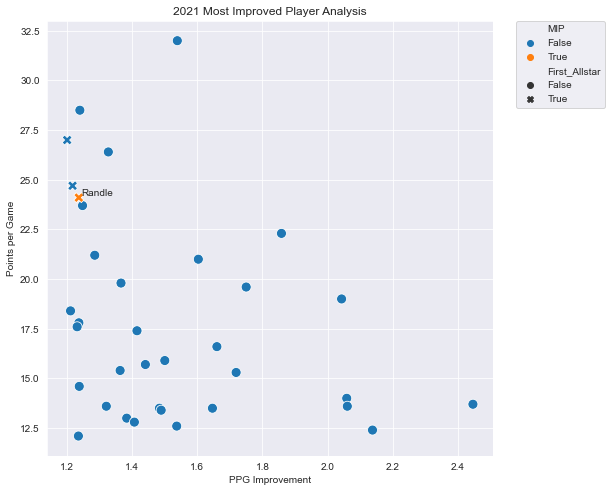

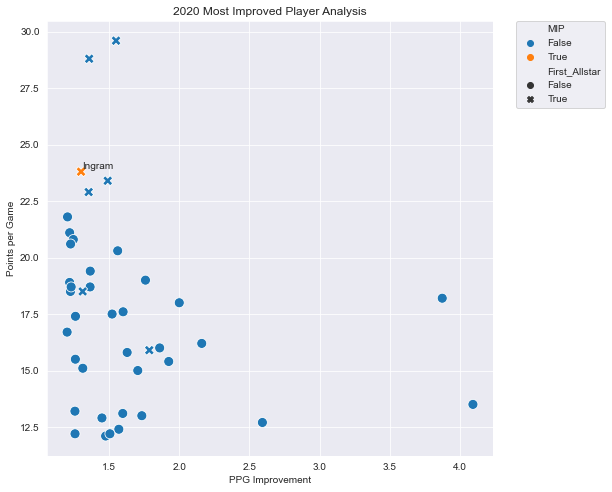

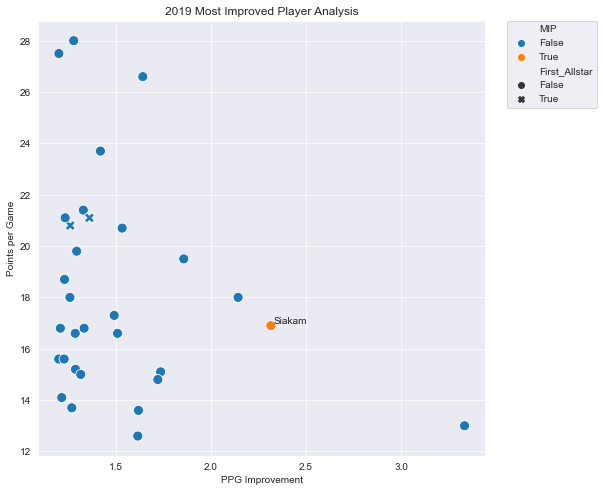

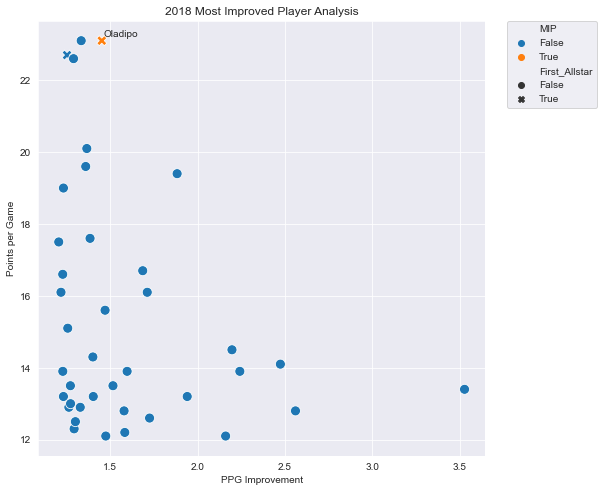

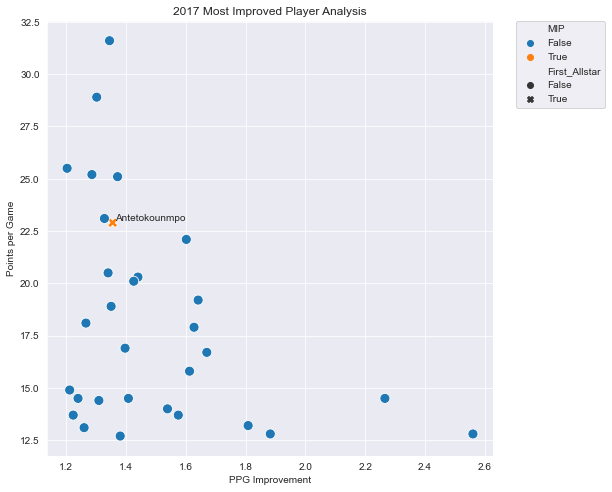

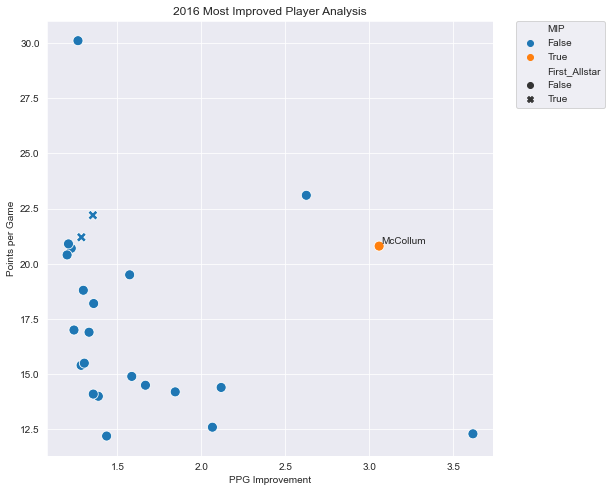

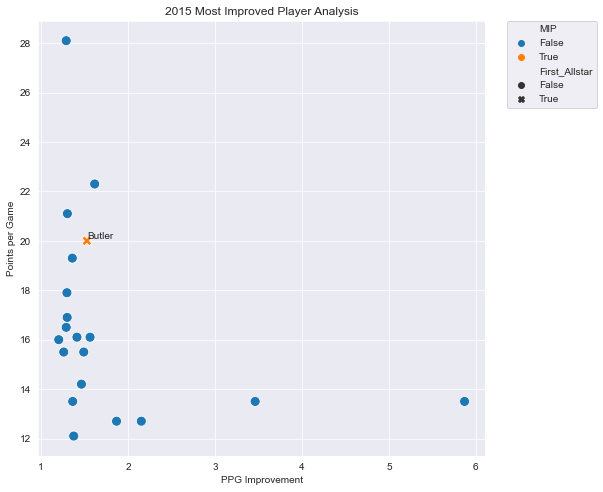

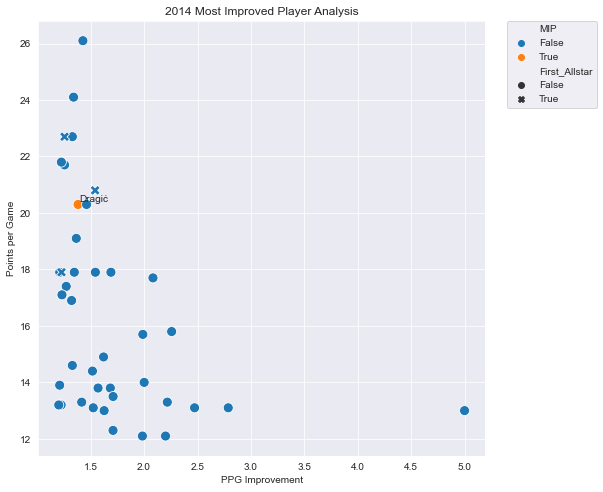

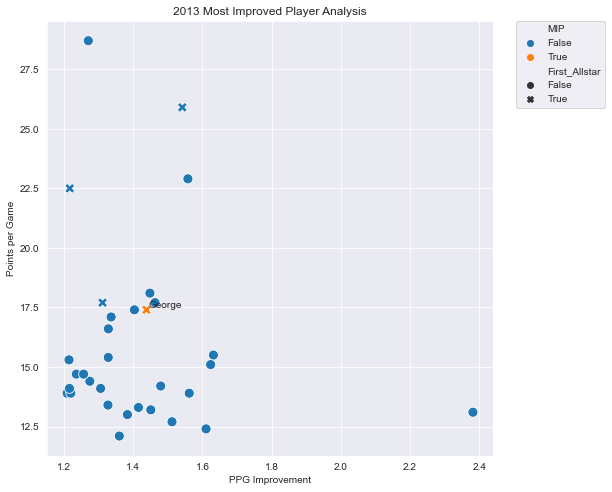

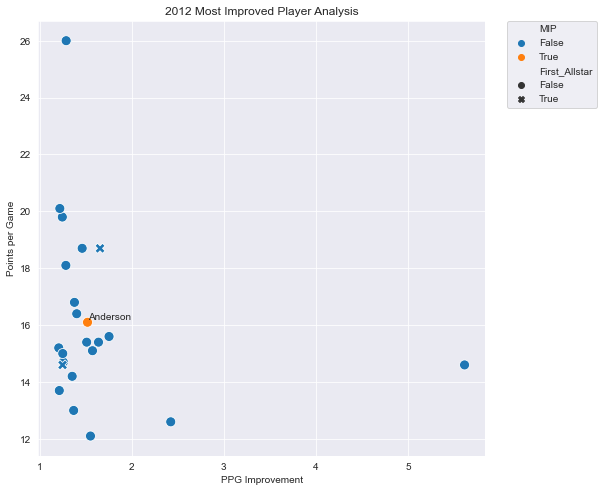

In [12]:
#Plot the last ten years of MIP data as scatterplots
#With PPG ratios on the x axis and current year PPG on the y-axis
#Highlight the winner of the MIP award that year in a different colour
#Highlight first time all-stars that year in a different marker
sns.set_style('darkgrid')

for year in year_dataframes:
    
    if year == 2022:
        continue
    
    #Only show players with a PPG improvement ratio of at least 1.2
    df = year_dataframes[year][year_dataframes[year]['PPG_Ratio'] >= 1.2].reset_index(drop=True)
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x='PPG_Ratio',y='PPG',data=df,s=100,hue='MIP',style='First_Allstar')
    
    #Find the data of the MIP winner
    winner_index = df[df['MIP']==1].index
    
    #Label the MIP winner with text on the chart
    if year < 2022:
        plt.text(np.array(df.iloc[winner_index]['PPG_Ratio'])[0]*1.005,
                 np.array(df.iloc[winner_index]['PPG'])[0]*1.005,
                np.array(df.iloc[winner_index]['Player'])[0].split()[-1])
    else:
        #Note some players on the chart
        players_of_note = df.sort_values(by='Improvement_Score',ascending=False)['Player'][:10]

        for i,player in enumerate(players_of_note):
            if player in historical_winners[year]:
                continue

            player_index = df[df['Player']==player].index
            player_data = df[df['Player']==player]

            #Label the player on the plot
            plt.annotate(player.split()[-1], xy=(np.array(df.iloc[player_index]['PPG_Ratio'])[0],
                         np.array(df.iloc[player_index]['PPG'])[0]),
                         size='x-small')

    
    #Label axis and title
    plt.xlabel('PPG Improvement')
    plt.ylabel('Points per Game')
    plt.title(str(year) + ' Most Improved Player Analysis')
    
    #Put the legend outside the chart
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

These graphs show that pure points per game improvement is not the only factor that voters consider when selecting their Most Improved Player.

## 4. Visualise Using Calculated Statistics

Going forward I will look at using points per game improvements divided by minutes per game changes. This will separate the effect of a player simply playing more minutes from the effect of the player improving. This statistic is referred to as 'Normalised Points per Game Ratio'.

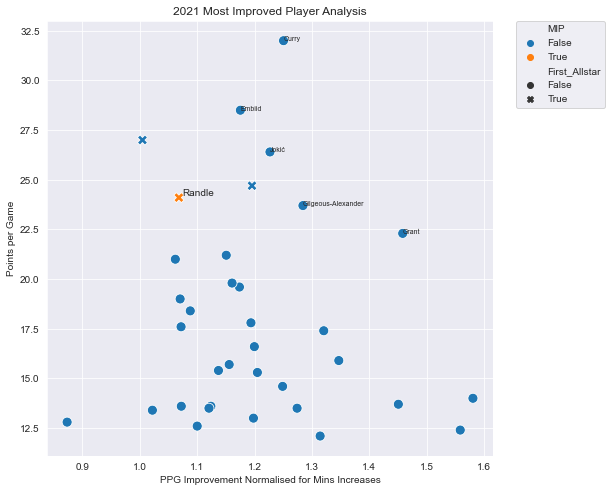

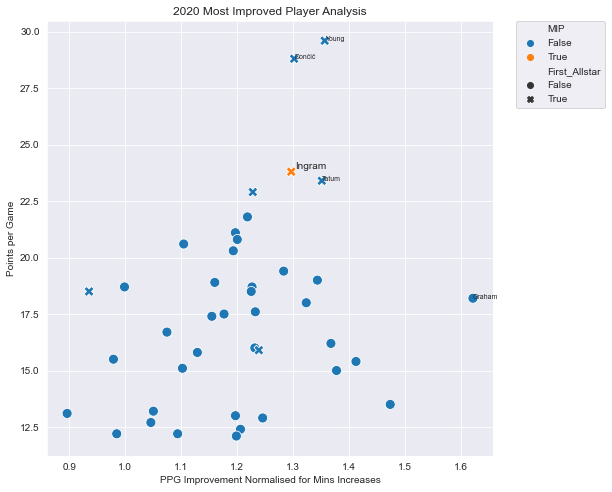

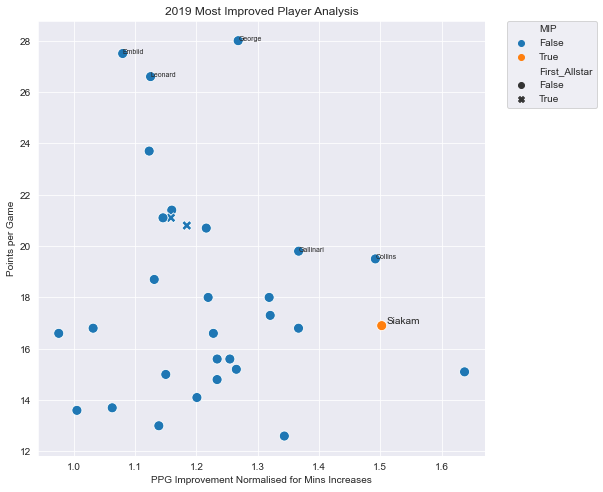

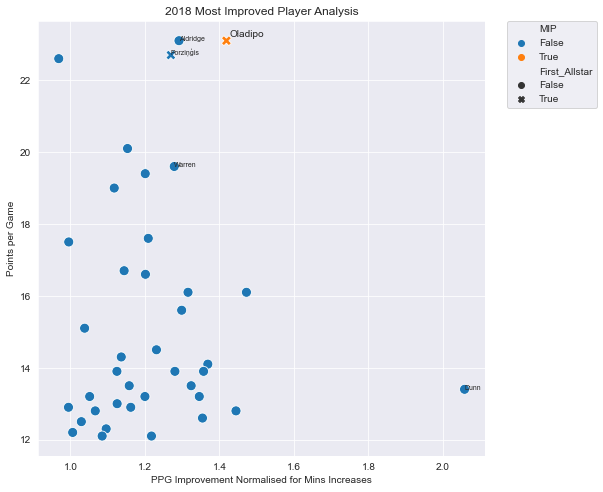

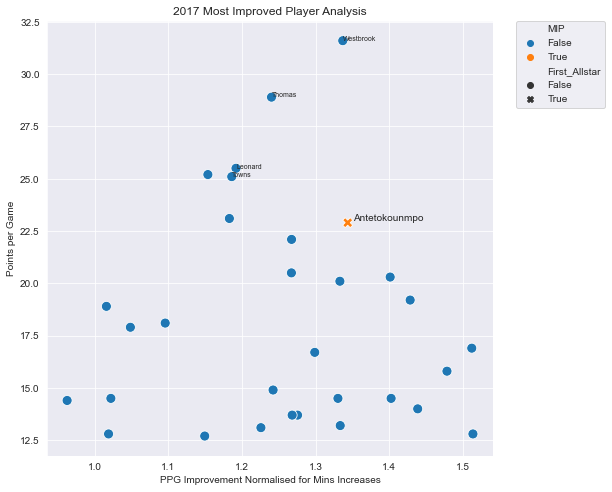

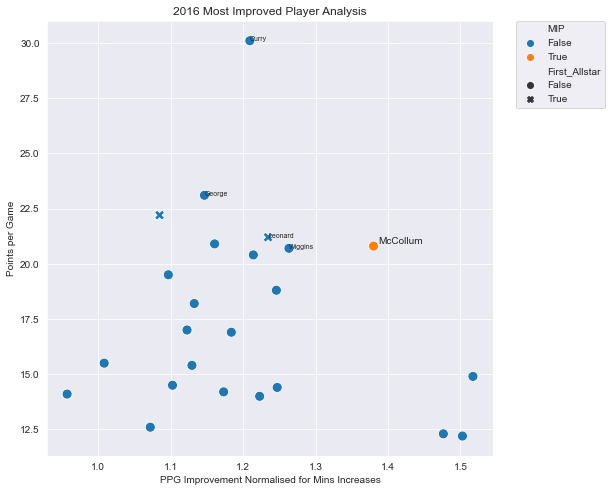

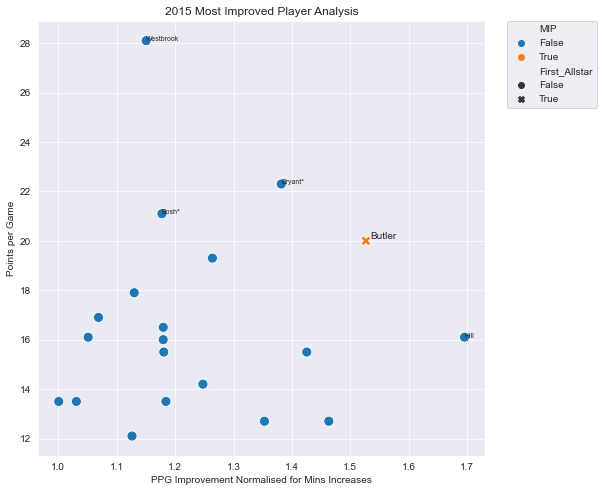

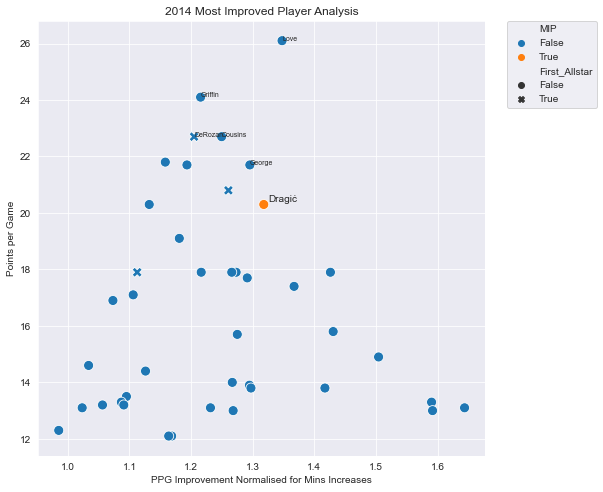

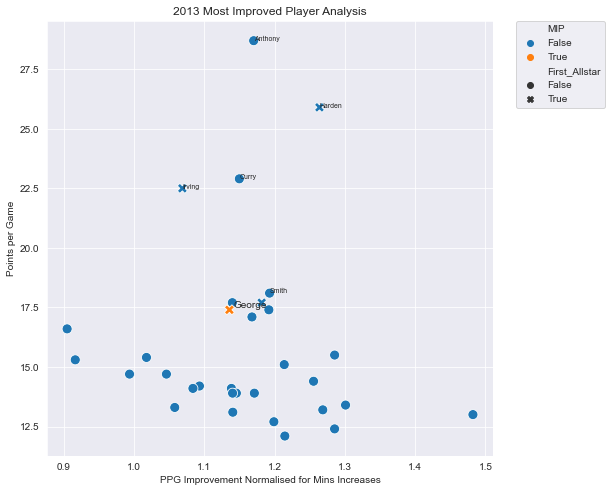

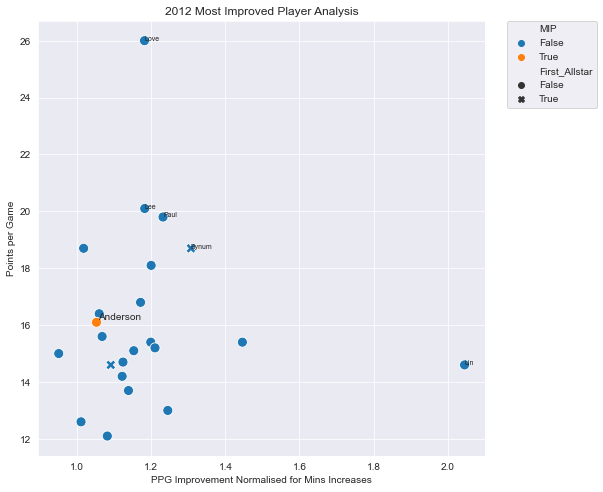

In [13]:
#Plot the last ten years of MIP data as scatterplots
#With Normalised PPG ratios on the x axis and current year PPG on the y-axis
#Highlight the winner of the MIP award that year in a different colour
#Highlight first time all-stars that year in a different marker
for year in year_dataframes:
    
    if year == 2022:
        continue
    
    #Only show players with a PPG improvement ratio of at least 1.2
    df = year_dataframes[year][year_dataframes[year]['PPG_Ratio'] >= 1.2].reset_index(drop=True)
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x='Norm_PPG_Ratio',y='PPG',data=df,s=100,hue='MIP',style='First_Allstar')
    
    #Find the data of the MIP winner
    winner_index = df[df['MIP']==1].index
    
    #Label the MIP winner with text on the chart
    if year < 2022:
        plt.text(np.array(df.iloc[winner_index]['Norm_PPG_Ratio'])[0]*1.005,
                 np.array(df.iloc[winner_index]['PPG'])[0]*1.005,
                np.array(df.iloc[winner_index]['Player'])[0].split()[-1])
        
    #Note some players on the chart
    players_of_note = list(df.sort_values(by='Normalised_Improvement_Score',ascending=False)['Player'][:5])

    for i,player in enumerate(players_of_note):
        if player in historical_winners[year]:
            continue
        
        player_index = df[df['Player']==player].index
        player_data = df[df['Player']==player]

        #Label the player on the plot
        if i % 2 == 0:
            x = 0.005
        else:
            x = -0.02
        plt.annotate(player.split()[-1], xy=(np.array(df.iloc[player_index]['Norm_PPG_Ratio'])[0],
                     np.array(df.iloc[player_index]['PPG'])[0]),
                     size='x-small'
                    )    
    
    #Label axis and title
    plt.xlabel('PPG Improvement Normalised for Mins Increases')
    plt.ylabel('Points per Game')
    plt.title(str(year) + ' Most Improved Player Analysis')
    
    #Put the legend outside the chart
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Normalised Improvement Score
Something to note is that many of the winners score more than 20 points per game, and many of the winners make their first all star appearance the year they win. This would suggest that all points improvements are not weighted equally by voters and the higher the current season points per game, the more weight voters seem to put on it. 

I calculate a 'Normalised Improvement Score'. This is done by calculating the product of a players Normalised Points per Game Ratio and their current season points per game. This statistic seeks to provide a single score which quantifies improvement with a weighting towards players who score more points per game.

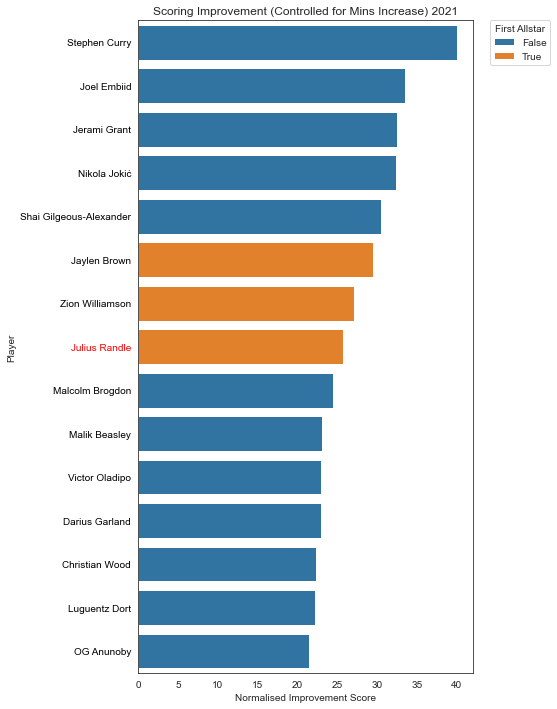

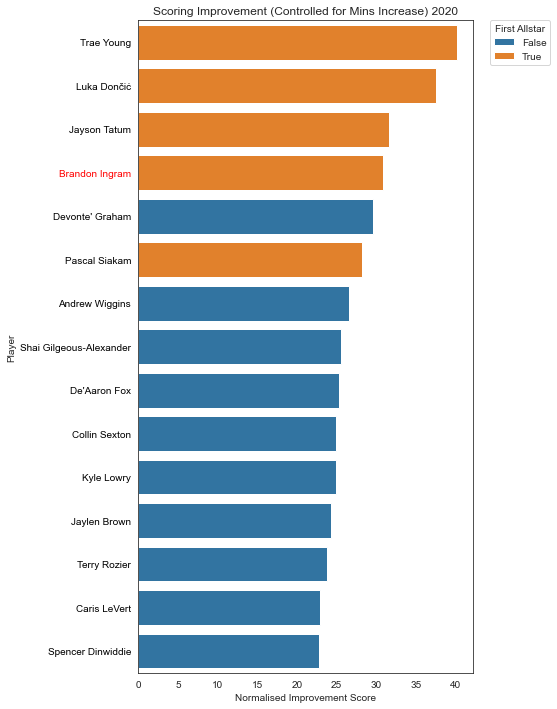

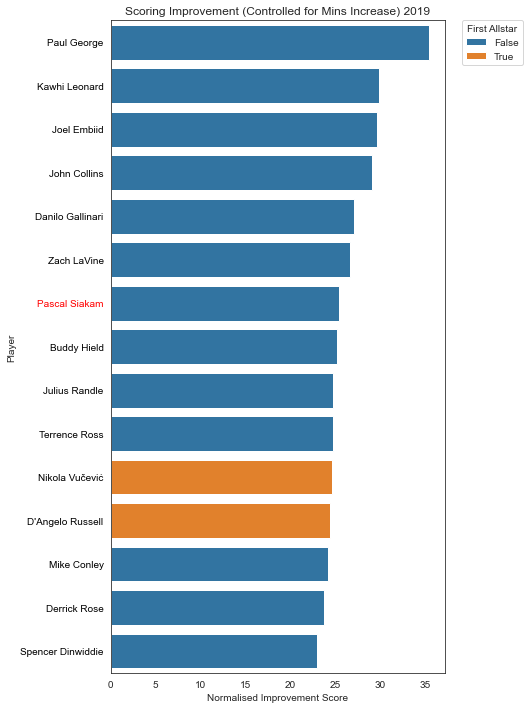

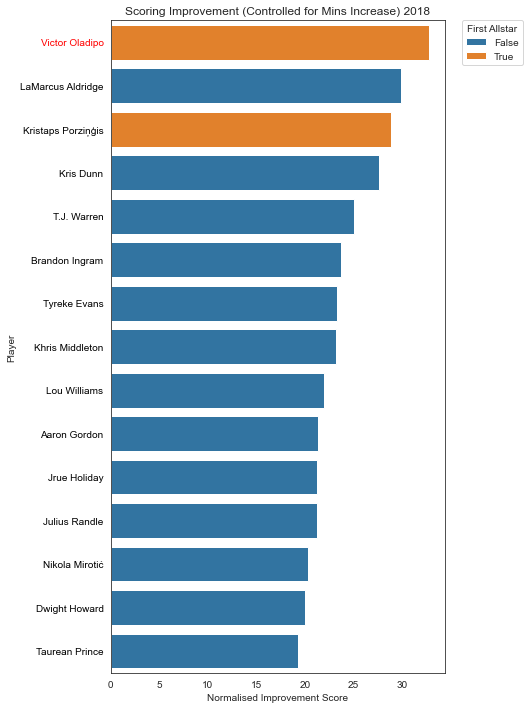

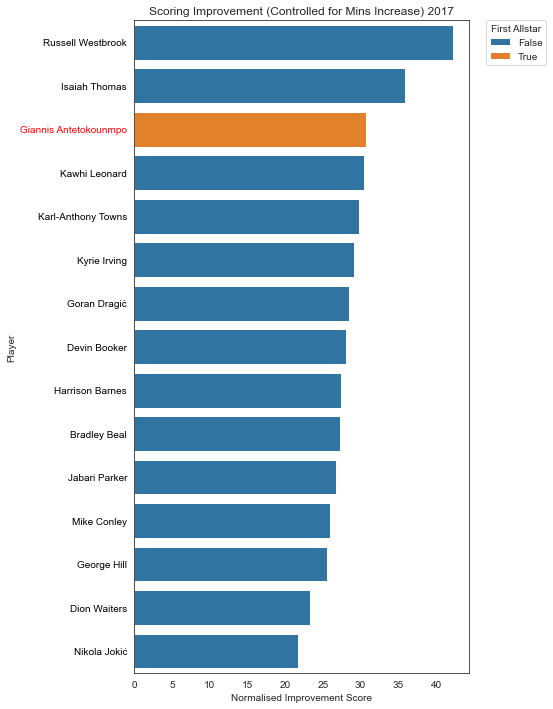

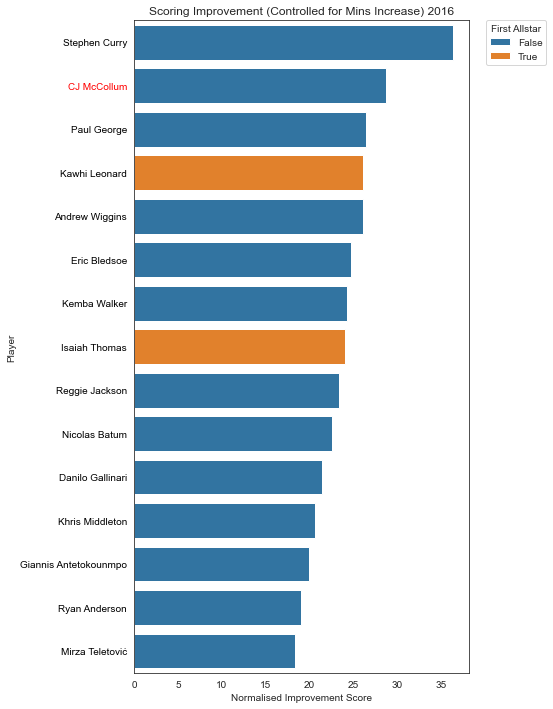

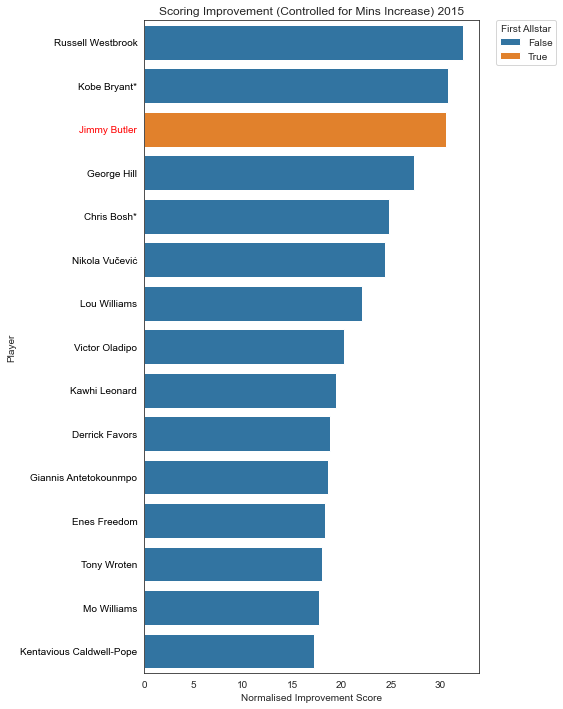

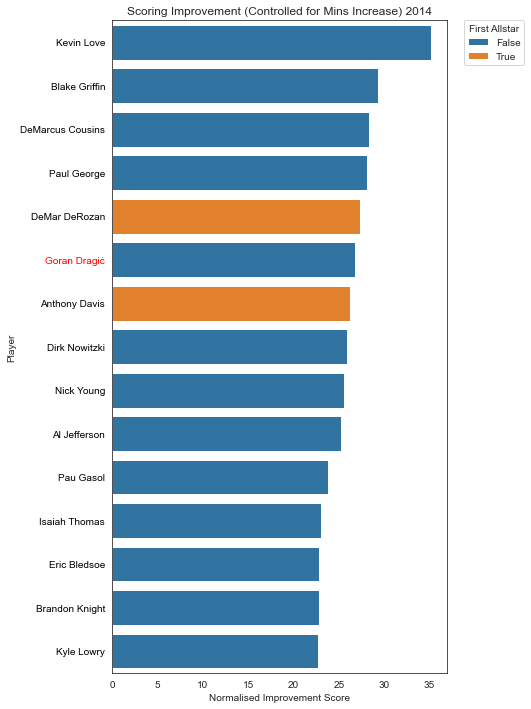

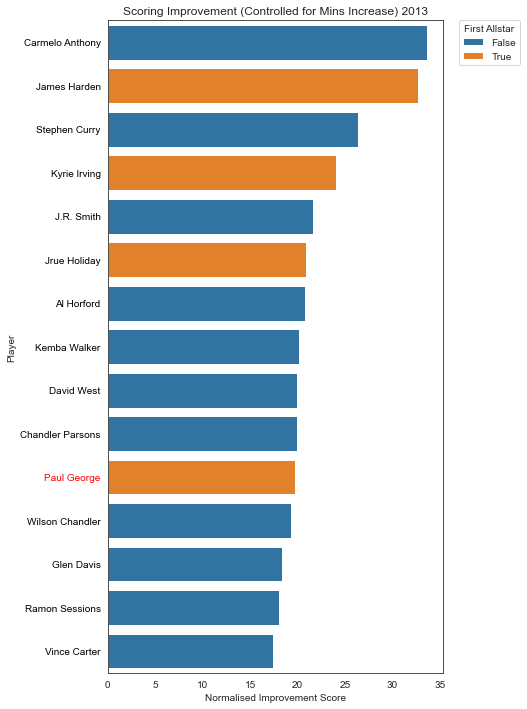

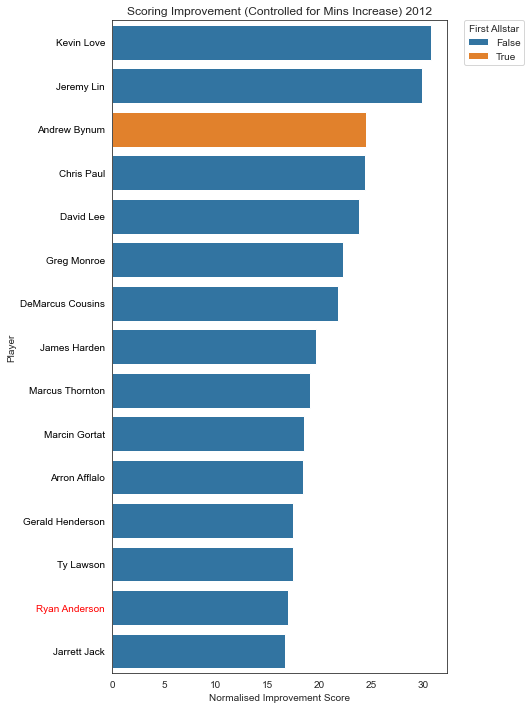

In [14]:
#Visualise the Normalised Improvement Score for the last 10 years
#Highlighting the players who were first time all stars in a different bar colour
#Highlighting the player who won the MIP award in red font
sns.set_style('white')

for year in year_dataframes:
    
    #Skip 2022 as we are only interested in historical data for now
    if year == 2022:
        continue
    #Only show players with a PPG improvement ratio of at least 1.2
    df = year_dataframes[year][year_dataframes[year]['PPG_Ratio'] >= 1.2].reset_index(drop=True)    
    
    plt.figure(figsize=(6,12))
    
    colors = sns.color_palette('Blues', n_colors=2)
    
    ax1 = sns.barplot(x='Normalised_Improvement_Score',y='Player',data=df.head(15)
                      ,hue='First_Allstar',dodge=False)
    
    plt.title('Scoring Improvement (Controlled for Mins Increase) ' + str(year))
    plt.xlabel('Normalised Improvement Score')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='First Allstar')
    
    #If a player won the MIP award for that year, highlight them in red font on the y-axis
    for (MIP, ticklbl) in zip(df['MIP'], ax1.yaxis.get_ticklabels()):
        ticklbl.set_color('red' if MIP == 1 else 'black')
        
    plt.show()

The ten plots above show that Normalised Improvement Score is a decent metric for predicting success in the Most Improved Player award, however it cannot be used alone to predict the winner.

Being a first time all-star does seem to have a correlation with winning the award as six of the last ten winners were first time all-stars, and other first time all-stars score well in Normalised Improvement Score.

Next I will explore the relationship between Normalised Improvement Score and the voting points won by players for the last ten years.

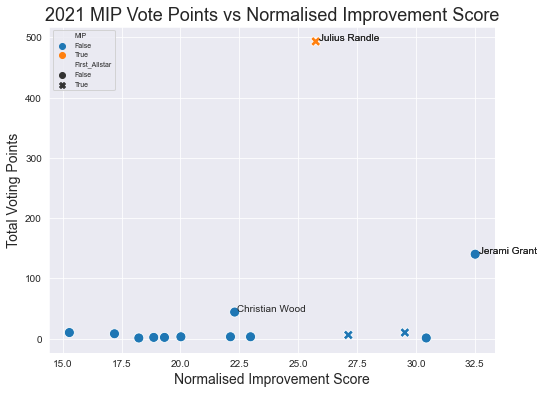

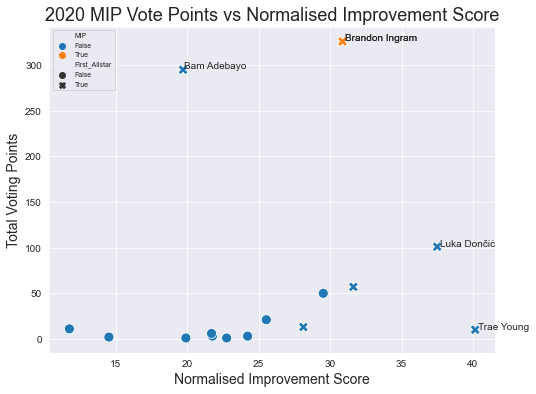

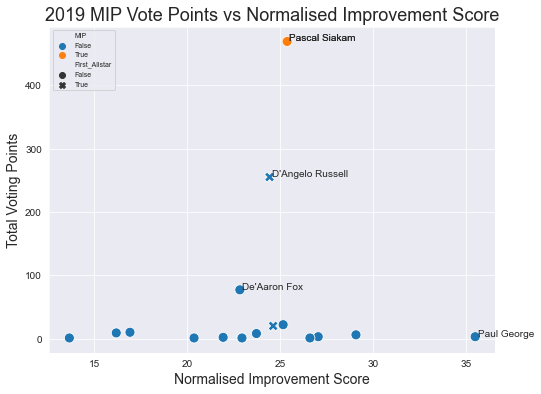

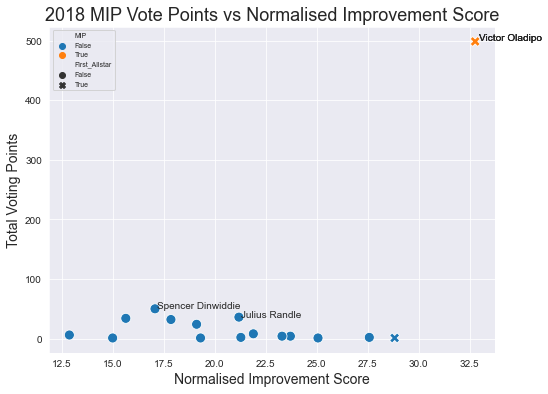

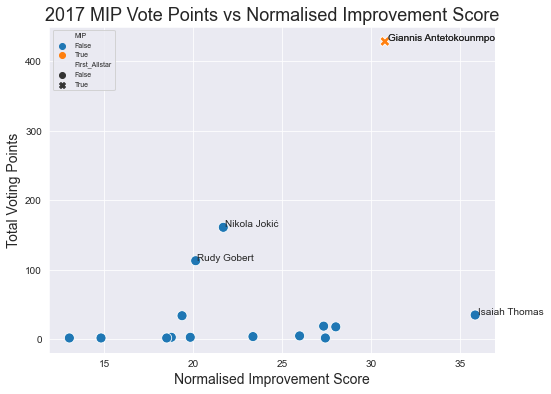

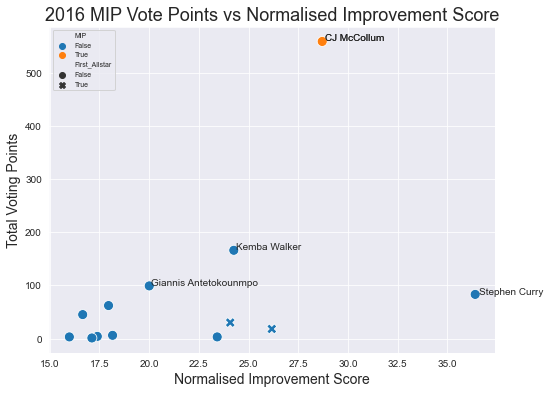

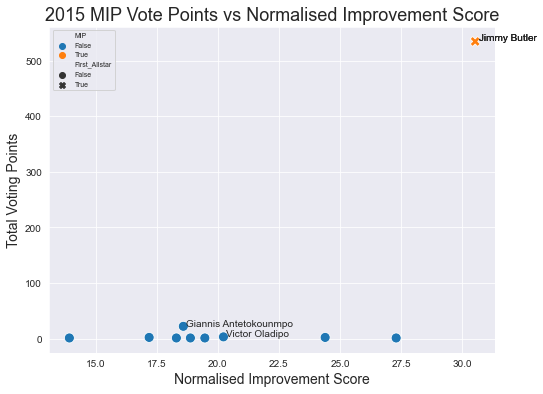

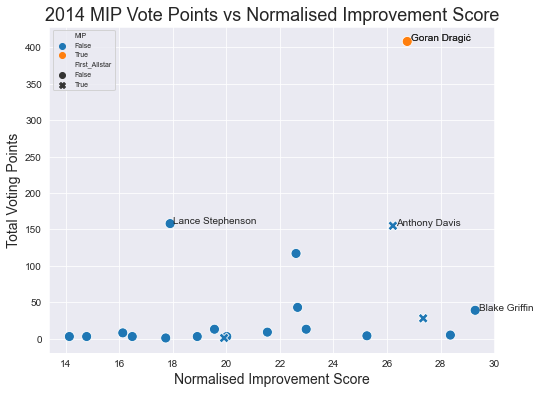

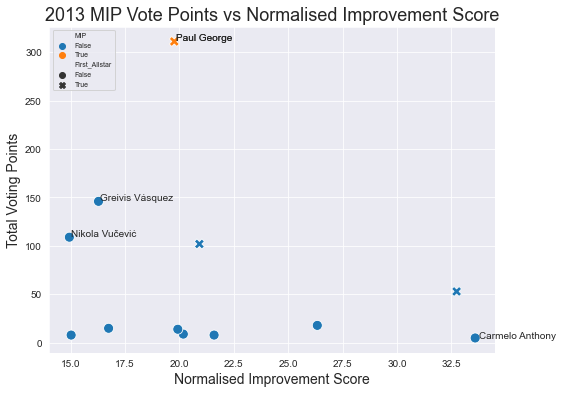

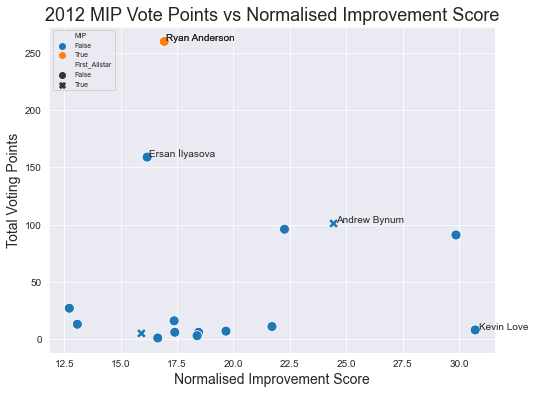

In [15]:
sns.set_style('darkgrid')

for year in year_dataframes:
    if year == 2022:
        continue
    plt.figure(figsize=(8,6))
    
    df = year_dataframes[year].loc[year_dataframes[year]['Pts Won'] > 0].reset_index(drop=True)
    
    #Only show players with a PPG improvement ratio of at least 1.2
    df = df[df['PPG_Ratio'] >= 1.2].reset_index(drop=True)
    
    sns.scatterplot(x='Normalised_Improvement_Score',y='Pts Won',
                    data=df,
                    hue='MIP',
                    style='First_Allstar',
                    s=100
                   )
    
    plt.title(str(year) + ' MIP Vote Points vs Normalised Improvement Score',fontdict={'size':18})
    plt.xlabel('Normalised Improvement Score',fontdict={'size':14})
    plt.ylabel('Total Voting Points',fontdict={'size':14})
    
    #Find the data of the MIP winner
    winner_index = df[df['MIP']==1].index
    
    #Find the data of the player with the highest normalised improvement score
    NIS_index = df['Normalised_Improvement_Score'].idxmax()
    
    #Label the MIP winner with text on the chart
    plt.text(np.array(df.iloc[winner_index]['Normalised_Improvement_Score'])[0]*1.005,
             np.array(df.iloc[winner_index]['Pts Won'])[0]*1.005,
            np.array(df.iloc[winner_index]['Player'])[0],
            fontdict={'size':10}) 
    
    #Label the MIP top 3 players with text on the chart
    top3 = df['Pts Won'].nlargest(3)
    
    for rank in top3:
        i = df[df['Pts Won']==rank].index
        
        plt.text(np.array(df.iloc[i]['Normalised_Improvement_Score'])[0]*1.005,
                 np.array(df.iloc[i]['Pts Won'])[0]*1.005,
                np.array(df.iloc[i]['Player'])[0],
                fontdict={'size':10})         
    
    #Label the Highest NIS on the chart
    plt.text(np.array(df.iloc[NIS_index]['Normalised_Improvement_Score'])*1.005,
             np.array(df.iloc[NIS_index]['Pts Won'])*1.005,
            np.array(df.iloc[NIS_index]['Player']),
             fontdict={'size':10})
    
    
    
    #Put the legend outside the chart
    plt.legend(loc='upper left',fontsize='x-small')

With the exception of Ryan Anderson in 2012, most of the award winners are on the right hand side of the charts and have a high Normalised Improvement Score for their year group.

Players who received votes for Most Improved Player generally score well in their Normalised Improvement Score, so it is a decent metric to quantify what voters think about when selecting their Most Improved Players.

In [16]:
#Use the same code as before but entering the 2022 and 2021 NBA seasons to look at the current year

#Get both dataframes of all players stats
current_year = get_season_data(2022)
current_year = drop_duplicate_players(current_year)

previous_year = get_season_data(2021)
previous_year = drop_duplicate_players(previous_year)

#Drop rows with missing data from dataframe - happening because so many 10-day contracts during Omicron
current_year.replace('',np.NaN,inplace=True)
current_year.dropna(inplace=True)
current_year.reset_index(drop=True)

#Only show players who are 40 and under
current_year = current_year[current_year['Age'].astype(int) <= 40]

#Only show players who score at least 12 ppg
current_year = current_year[current_year['PTS'].astype(float) > 12]

#Only show players who played at least 15 games
current_year = current_year[current_year['G'].astype(int) >= 15]

#Get a list of players that have played in both seasons
mip_candidates = []
for player in list(current_year['Player']):
    if player in list(previous_year['Player']):
        mip_candidates.append(player)

#filter both dataframes to contain only players eligible for MIP award
current_year = current_year[current_year['Player'].isin(mip_candidates)].reset_index(drop=True)
previous_year = previous_year[previous_year['Player'].isin(mip_candidates)].reset_index(drop=True)


#Calculate this years improvement stats and rank
data = {'Player': mip_candidates,'Team': [], 'PPG_Ratio': [],'Mins_Ratio': [], 'PPG': [], 'Norm_PPG_Ratio': []}
for player in mip_candidates:
    if player == 'Chris Johnson':
        data['PPG_Ratio'].append(np.nan)
        data['Mins_Ratio'].append(np.nan)
        data['PPG'].append(np.nan)
        data['Norm_PPG_Ratio'].append(np.nan)
        continue
    
    team = current_year[current_year['Player']==player]['Tm'].item()
    
    #If their mins or ppg in previous year were 0 then continue      
    ppg_current = round(float(current_year[current_year['Player']==player]['PTS']),2)
    ppg_previous = round(float(previous_year[previous_year['Player']==player]['PTS']),2)

    mpg_current = round(float(current_year[current_year['Player']==player]['MP']),2)
    mpg_previous = round(float(previous_year[previous_year['Player']==player]['MP']),2)

    if ppg_previous < 0.1:
        data['PPG_Ratio'].append(np.nan)
        data['Mins_Ratio'].append(np.nan)
        data['PPG'].append(ppg_current)
        data['Norm_PPG_Ratio'].append(np.nan)
        continue
    if mpg_previous < 0.1:
        data['PPG_Ratio'].append(np.nan)
        data['Mins_Ratio'].append(np.nan)
        data['PPG'].append(ppg_current)
        data['Norm_PPG_Ratio'].append(np.nan)
        continue

    ppg_ratio = ppg_current / ppg_previous
    mins_ratio = mpg_current / mpg_previous

    norm_ppg_ratio = ppg_ratio / mins_ratio

    data['PPG_Ratio'].append(ppg_ratio)
    data['Mins_Ratio'].append(mins_ratio)
    data['PPG'].append(ppg_current)
    data['Norm_PPG_Ratio'].append(norm_ppg_ratio)
    data['Team'].append(team)

ratio_data = pd.DataFrame.from_dict(data)
ratio_data['Improvement_Score'] = ratio_data['PPG_Ratio'] * ratio_data['PPG']
ratio_data['Normalised_Improvement_Score'] = ratio_data['Improvement_Score'] / ratio_data['Mins_Ratio']

#Boolean for first time allstars
ratio_data['First_Allstar'] = ratio_data['Player'].isin(first_time_allstars[year])

#Boolean for winner of Most Improved Player
ratio_data['MIP'] = ratio_data['Player'].isin(historical_winners[year])

ratio_data = ratio_data.sort_values(by='Normalised_Improvement_Score',ascending=False).reset_index(drop=True)

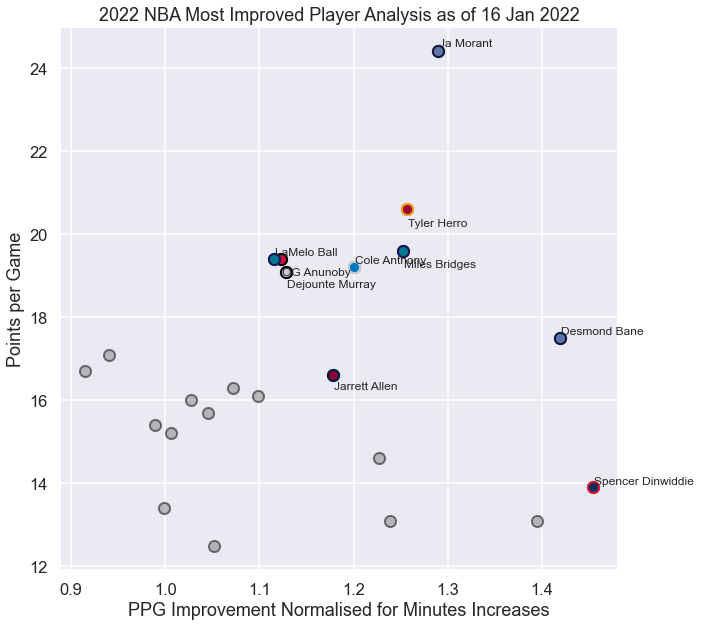

In [17]:
#Set the style of the plot that is generated
sns.set_context('talk')
sns.set_style('darkgrid')

#Only look at players with a PPG Improvement Ratio of at least 1.2
df = ratio_data[ratio_data['PPG_Ratio'] >= 1.2].reset_index(drop=True)

plt.figure(figsize=(10,10))

#Plot the data
sns.scatterplot(x='Norm_PPG_Ratio',y='PPG',data=df,s=125,color='grey',edgecolor='black',linewidth=2,alpha=0.5)

#Take the top three favourites from the betting market and note them on the plot
players_of_note = list(df.sort_values(by='Normalised_Improvement_Score',ascending=False)['Player'][:10])

for i,player in enumerate(players_of_note):
    
    player_index = df[df['Player']==player].index
    player_data = df[df['Player']==player]
    
    team = player_data['Team'].item()
    colour1 = team_colours[team]['primary']
    colour2 = team_colours[team]['secondary']
    
    #Plot the player in a different colour
    sns.scatterplot(x='Norm_PPG_Ratio',y='PPG',data=player_data,s=125,
                    color=colour1,edgecolor=colour2,linewidth=2)
    
    #Label the player on the plot
    if i % 2 == 0:
        x = 0.005
    else:
        x = -0.02
    plt.text(np.array(df.iloc[player_index]['Norm_PPG_Ratio'])[0]*(1+0.001),
             np.array(df.iloc[player_index]['PPG'])[0]*(1+x),
             np.array(df.iloc[player_index]['Player'])[0],
            fontdict={'size':12})

#Label the graph
plt.xlabel('PPG Improvement Normalised for Minutes Increases')
plt.ylabel('Points per Game')
today = date.today().strftime('%d %b %Y')
plt.title(str(2022) + ' NBA Most Improved Player Analysis as of ' + today)
plt.tight_layout

#Save a copy of todays standings to compare over time
if date.today().weekday() in [0,4]:
    plt.savefig('MIP Analysis ' + today, bbox_inches='tight')

As we have seen previously, the Most Improved Player award usually goes to a player who is making their first all-star appearance. For this reason I will demove DeMar DeRozan as he has already made four appearances, and also had a previous season where he averaged more points per game than this year (2016/17).

Other players ranking highly but who have also previously had better seasons include Kevin Love, Ricky Rubio, Reggie Jackson, Spencer Dinwiddie and Marcus Morris, so they are removed.

The award also rarely goes to players in their sophmore year. The last player to win the award in his second year in the league was Gilbert Arenas in 2002/03. Since it is possible I will leave these players in the graph, however their inclusion should be noted as less likely due to being second year players.

Lastly Tyler Herro is not a starter for the Miami Heat, and despite showing good statistical improvement he is a heavy favourite for the Sixth Man of the Year Award. For this reason I will exclude him from the graph as it is highly unlikely a player will win both.

Generating the graph again without the players mentioned returns this:

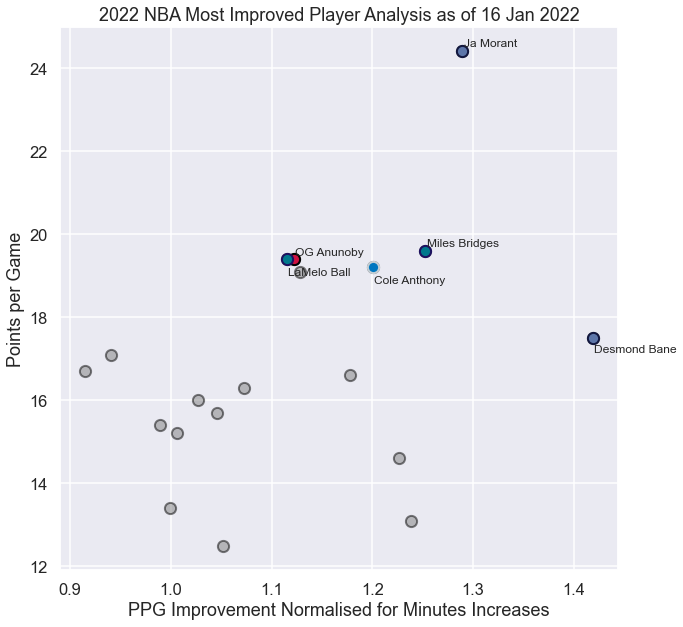

In [18]:
#Only look at players with a PPG Improvement Ratio of at least 1.2
df = ratio_data[ratio_data['PPG_Ratio'] >= 1.2].reset_index(drop=True)

#Filtering out players mentioned
players_to_remove = ['DeMar DeRozan', 'Tyler Herro', 
                     'Ricky Rubio', 'Kevin Love', 'Reggie Jackson', 'Spencer Dinwiddie', 'Marcus Morris']

df = df[~df['Player'].isin(players_to_remove)].reset_index(drop=True)

plt.figure(figsize=(10,10))

#Plot the data
sns.scatterplot(x='Norm_PPG_Ratio',y='PPG',data=df,s=125,color='grey',edgecolor='black',linewidth=2,alpha=0.5)

#Take the top three favourites from the betting market and note them on the plot
players_of_note = list(df.sort_values(by='Normalised_Improvement_Score',ascending=False)['Player'][:6])

for i,player in enumerate(players_of_note):
    
    player_index = df[df['Player']==player].index
    player_data = df[df['Player']==player]
    
    team = player_data['Team'].item()
    colour1 = team_colours[team]['primary']
    colour2 = team_colours[team]['secondary']
    
    #Plot the player in a different colour
    sns.scatterplot(x='Norm_PPG_Ratio',y='PPG',data=player_data,s=125,
                    color=colour1,edgecolor=colour2,linewidth=2)
    
    #Label the player on the plot
    if i % 2 == 0:
        x = 0.005
    else:
        x = -0.02
    plt.text(np.array(df.iloc[player_index]['Norm_PPG_Ratio'])[0]*(1+0.001),
             np.array(df.iloc[player_index]['PPG'])[0]*(1+x),
             np.array(df.iloc[player_index]['Player'])[0],
            fontdict={'size':12})

#Label the graph
plt.xlabel('PPG Improvement Normalised for Minutes Increases')
plt.ylabel('Points per Game')
today = date.today().strftime('%d %b %Y')
plt.title(str(2022) + ' NBA Most Improved Player Analysis as of ' + today)
plt.tight_layout

#Save a copy of todays standings to compare over time
if date.today().weekday() in [0,4]:
    plt.savefig('MIP Analysis ' + today, bbox_inches='tight')

By filtering out the previous players, Ja Morant stands out as the most likely player to win the Most Improved Player award in 2022. He is currently 3rd in fan voting for an all-star spot in the west guards so it's extremely likely he will be a first time all-star. 

Summarising the above chart into the single statistic of Normalised Improvement Score gives the table and chart below.

            Player  Normalised_Improvement_Score
0        Ja Morant                     31.460192
1     Desmond Bane                     24.826869
2    Miles Bridges                     24.550980
3     Cole Anthony                     23.048505
4       OG Anunoby                     21.774190
5      LaMelo Ball                     21.642410
6  Dejounte Murray                     21.547621
7    Jarrett Allen                     19.547009
8  Anfernee Simons                     17.908256
9       Seth Curry                     17.479205


Text(0, 0.5, '')

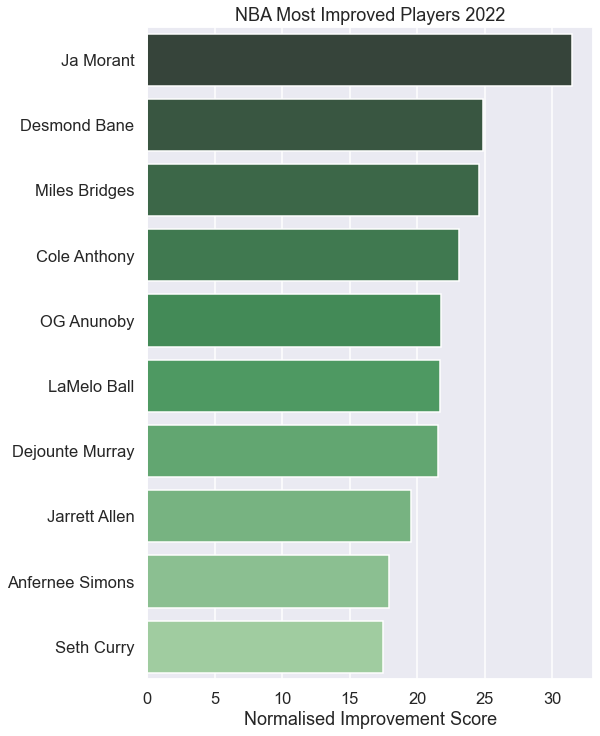

In [19]:
score = df[['Player','Normalised_Improvement_Score']].sort_values(by='Normalised_Improvement_Score',
                                                                  ascending=False).reset_index(drop=True).head(10)
print(score)

plt.figure(figsize=(8,12))

sns.set_context('talk')

pal = sns.color_palette("Greens_d", len(score))
rank = score['Normalised_Improvement_Score'].argsort()

sns.barplot(y='Player',x='Normalised_Improvement_Score',data=score,palette=np.array(pal[::1])[rank])

plt.title('NBA Most Improved Players 2022')

plt.xlabel('Normalised Improvement Score')

plt.ylabel("")

In [20]:
score

,Player,Normalised_Improvement_Score
0,Ja Morant,31.460192
1,Desmond Bane,24.826869
2,Miles Bridges,24.550980
3,Cole Anthony,23.048505
4,OG Anunoby,21.774190
5,LaMelo Ball,21.642410
6,Dejounte Murray,21.547621
7,Jarrett Allen,19.547009
8,Anfernee Simons,17.908256
9,Seth Curry,17.479205


## Exploring Advanced Stats

Here I incorporate some advanced statistics into my analysis to see if they can give a better picture than simple box score statistics.

Firstly I plot Normalised Improvement Score against year-on-year difference in Box Plus-Minus (BPM) to see if there is a relationship with previous Most Improved Player winners.

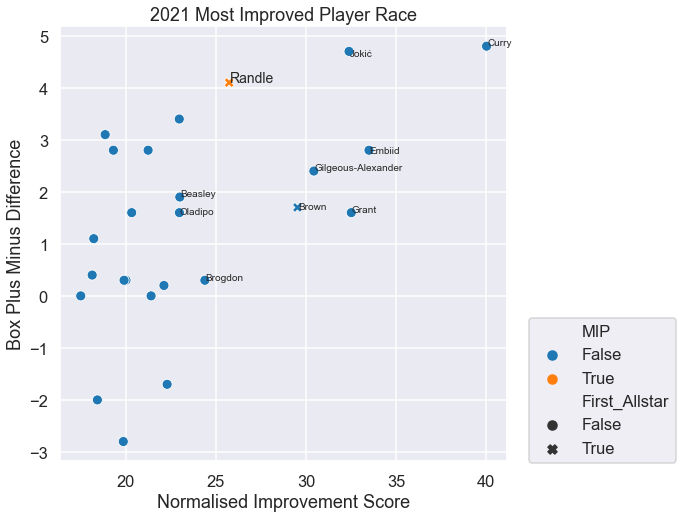

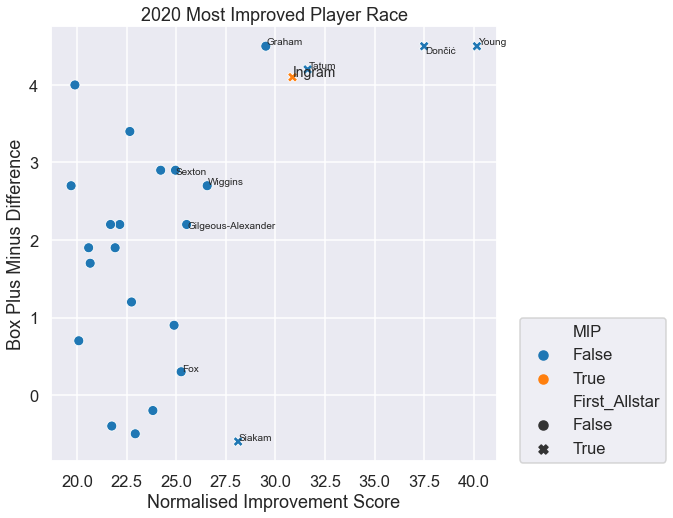

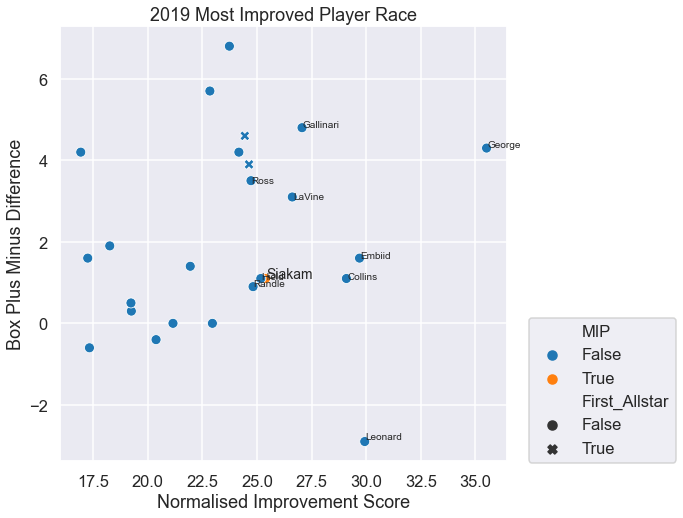

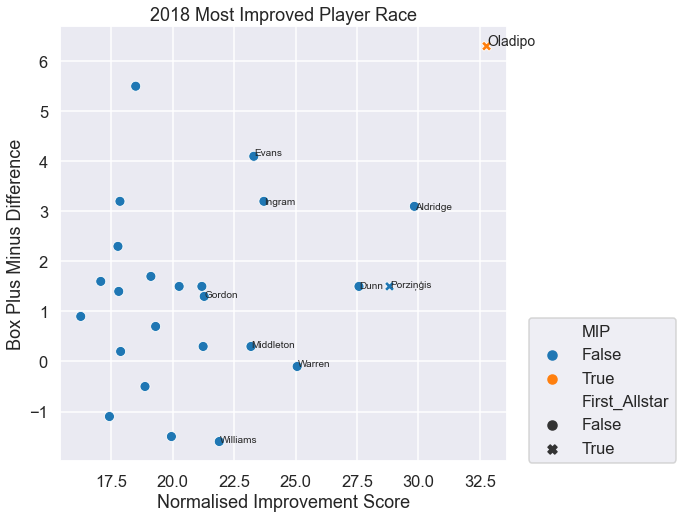

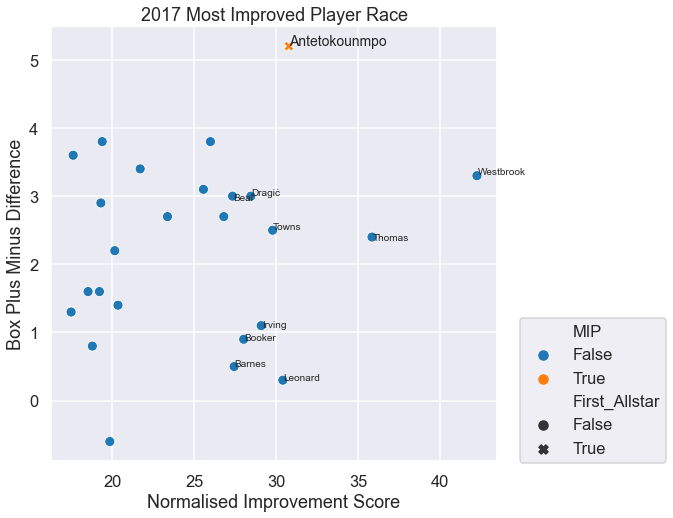

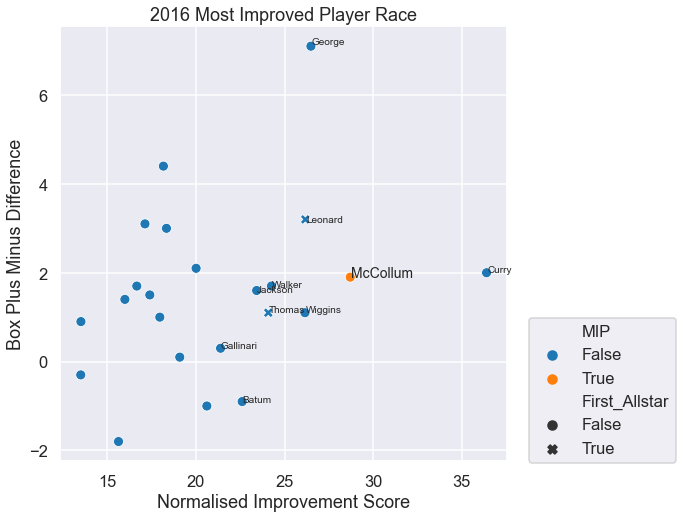

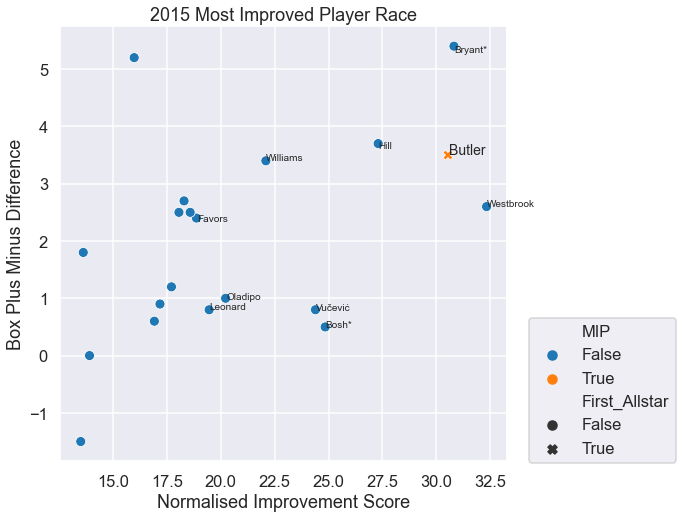

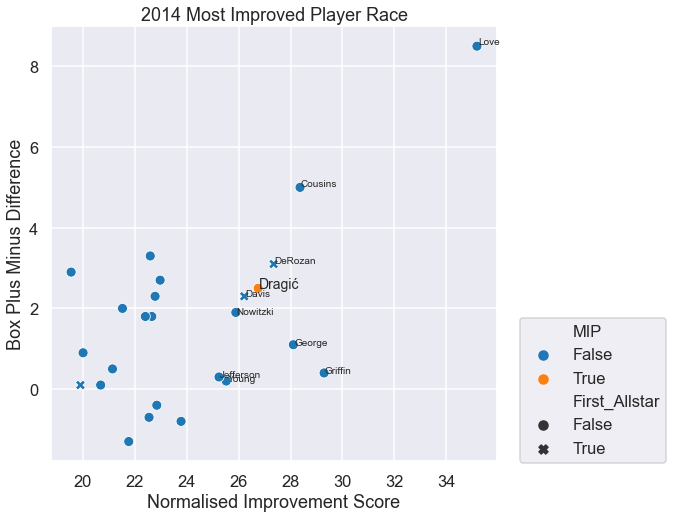

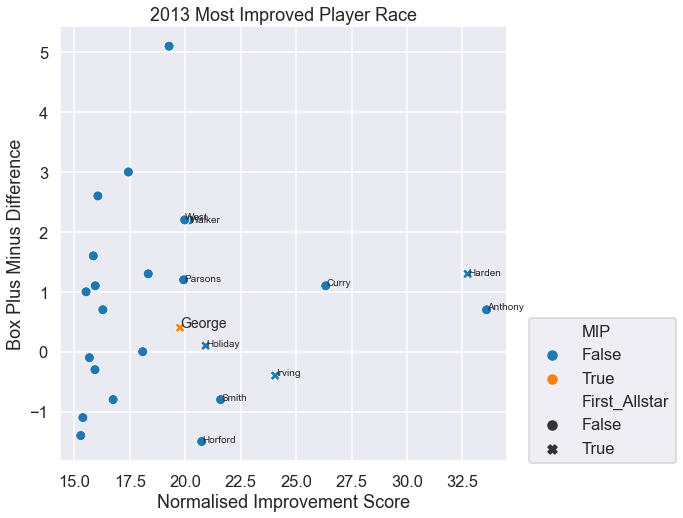

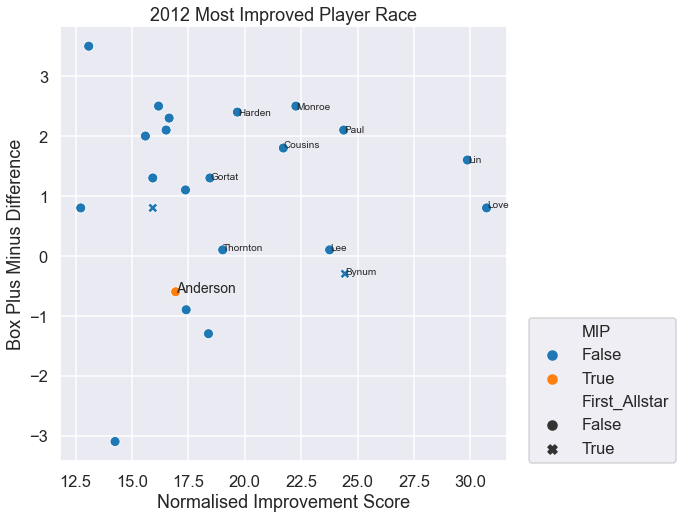

In [21]:
for year in year_dataframes:
    
    #Skip 2022, only interested in historical data for now
    if year == 2022:
        continue
    
    #Only include players that have increased their scoring by at least 20%
    df = year_dataframes[year]
    
    df = df.loc[df['PPG_Ratio'] > 1.2].reset_index(drop=True)
    
    df = df.sort_values(by='Normalised_Improvement_Score',ascending=False).reset_index(drop=True).head(25)
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(data=df,x='Normalised_Improvement_Score',y='BPM_Diff',
                    hue='MIP',
                    style='First_Allstar',
                    s=100)
    
    plt.legend(bbox_to_anchor=(1.05, 0.33), loc=2, borderaxespad=0.)
    
    #Put text over players of note
    players_of_note = df['Player'][:10]

    for i,player in enumerate(players_of_note):
        if player in historical_winners[year]:
            continue
        player_index = df[df['Player']==player].index
        player_data = df[df['Player']==player]

        #Label the player on the plot
        if i % 2 == 0:
            x = 0.005
        else:
            x = -0.02
        plt.text(np.array(df.iloc[player_index]['Normalised_Improvement_Score'])*(1+0.001),
                 np.array(df.iloc[player_index]['BPM_Diff'])*(1+x),
                 np.array(player.split()[-1]),
                fontdict={'size':10})
        
    for player in historical_winners[year]:
        player_index = df[df['Player']==player].index
        player_data = df[df['Player']==player]

        #Label the player on the plot
        plt.text(np.array(df.iloc[player_index]['Normalised_Improvement_Score'])*(1+0.001),
                 np.array(df.iloc[player_index]['BPM_Diff'])*(1+0.002),
                 np.array(player.split()[-1]),
                fontdict={'size':14})
        
    plt.title(str(year) + ' Most Improved Player Race')

    plt.xlabel('Normalised Improvement Score')

    plt.ylabel('Box Plus Minus Difference')

BPM difference does not seem to differentiate candidates for Most Improved Player any better than the simple box score statistics do. If anything it introduces more players to the area of the plot containing the winners, which brings more noise to the graphs and less signal.

By calculating the product of Box Plus Minus Difference and Normalised Improvement Score I can create a single metric that combines a players points scored improvements (normalised for minutes increases) with the difference in their impact on points contributed per 100 possessions in comparison with a league average player on a league average team.

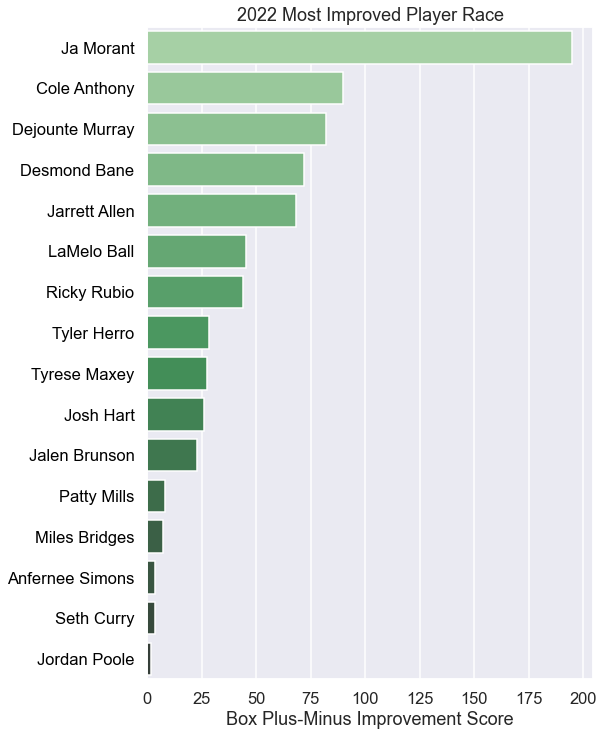

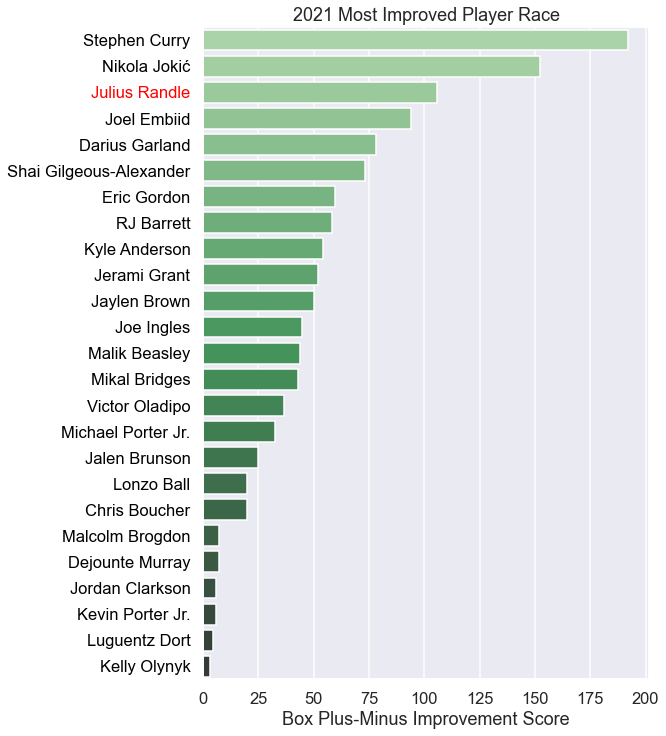

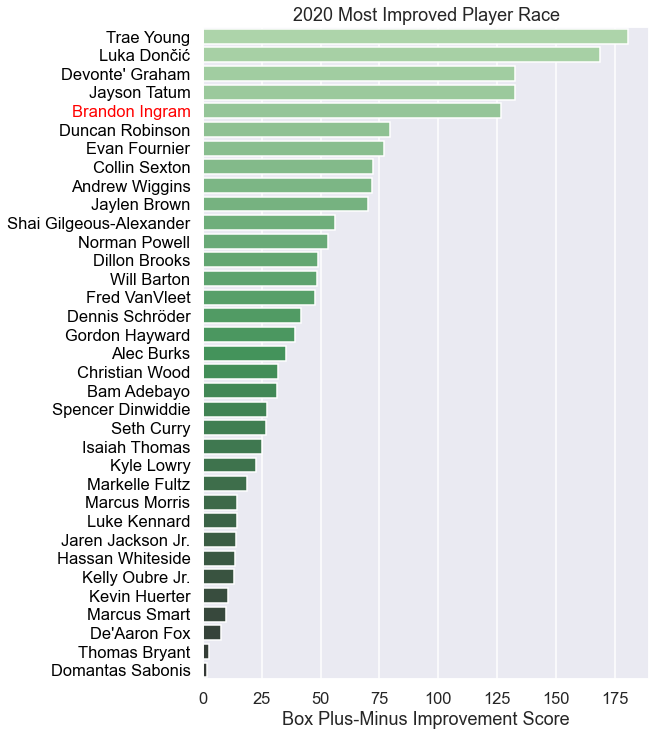

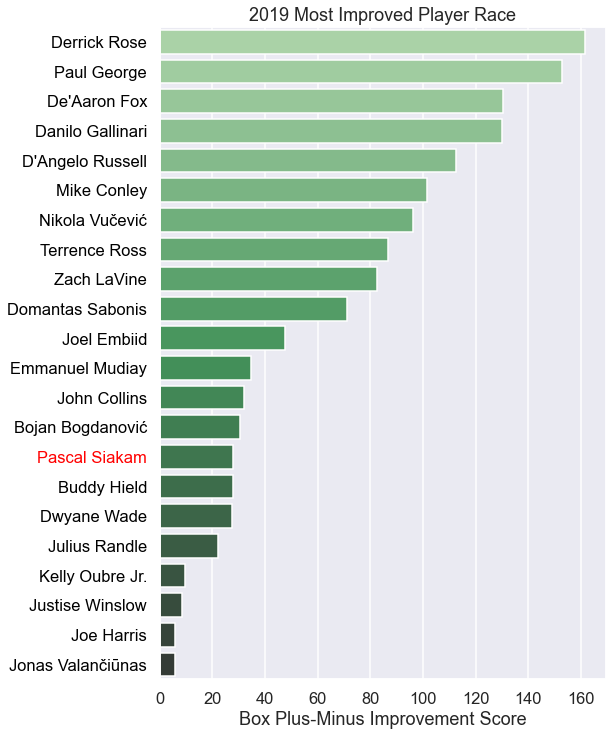

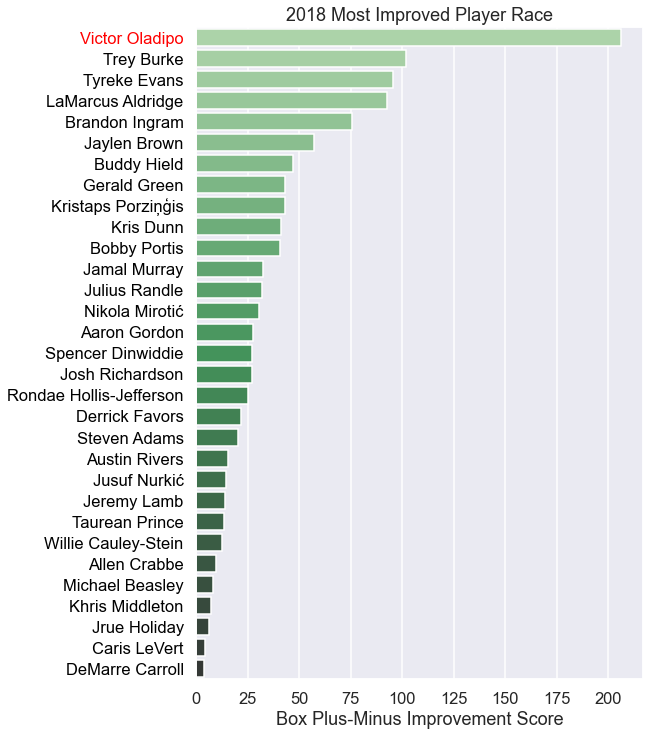

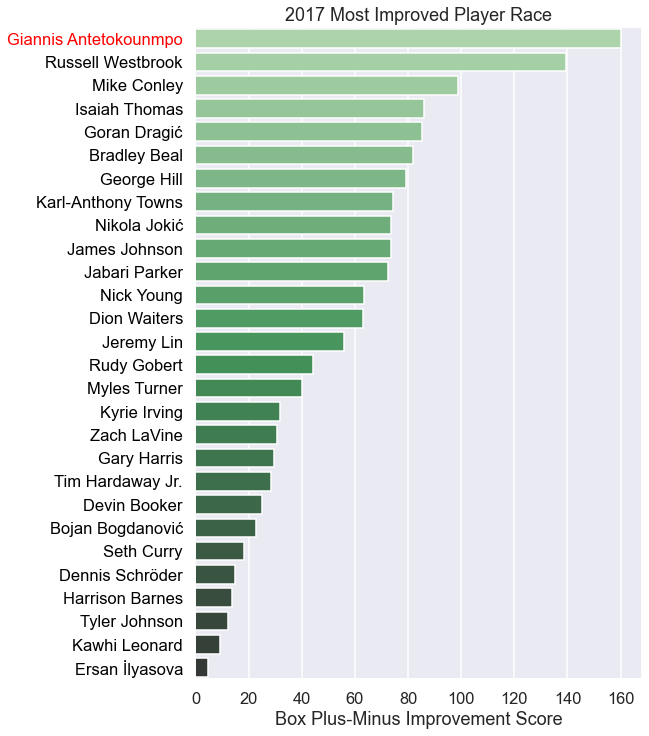

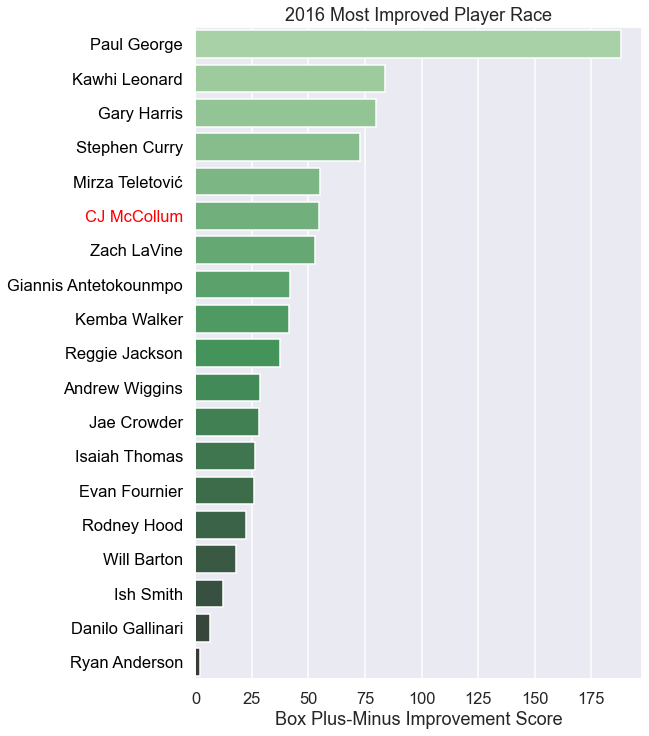

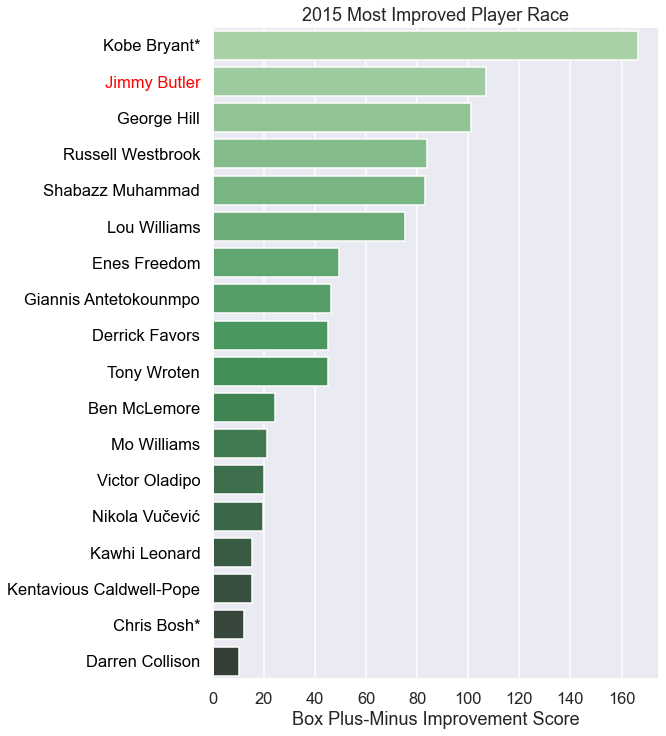

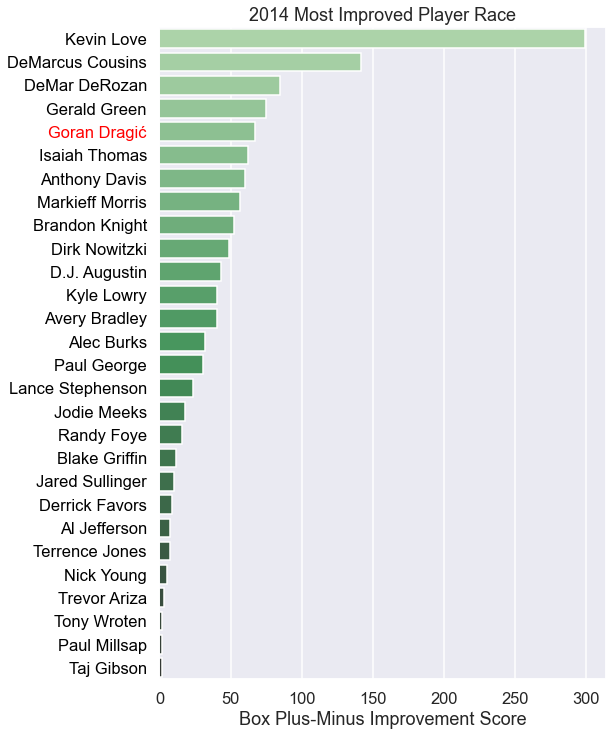

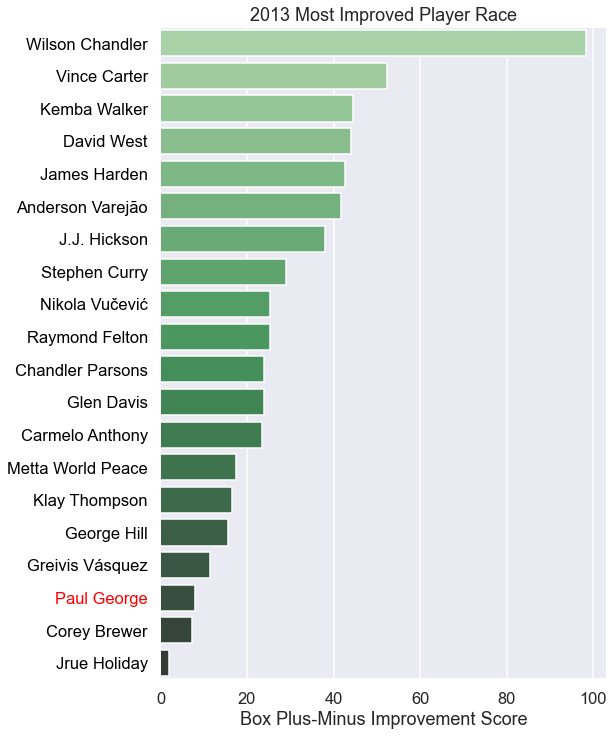

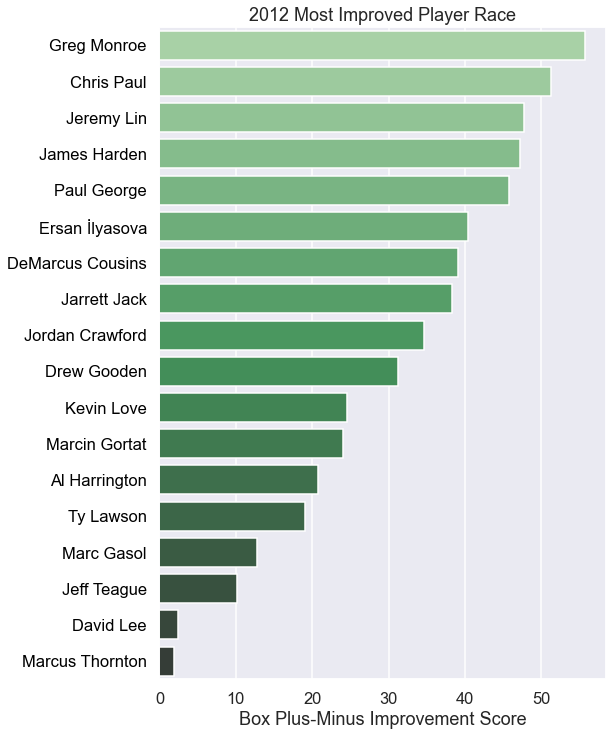

In [22]:
for year in year_dataframes:
    
    #Only include players that have increased their scoring by at least 20%
    df = year_dataframes[year]
    
    df = df.loc[df['PPG_Ratio'] > 1.2].reset_index(drop=True)
    
    df = df.sort_values(by='Normalised_Improvement_Score',ascending=False).reset_index(drop=True).head(50)
    
    df['BPM_Scoring_Improvement'] = df['BPM_Diff'] * df['Normalised_Improvement_Score']
    
    score = df[['Player','BPM_Scoring_Improvement', 
                'MIP', 'First_Allstar']].sort_values(by='BPM_Scoring_Improvement',
                                                     ascending=False).reset_index(drop=True)
    
    score = score.loc[score['BPM_Scoring_Improvement'] > 0]
    
    plt.figure(figsize=(8,12))

    pal = sns.color_palette("Greens_d", len(score))
    rank = rank = score['BPM_Scoring_Improvement'].argsort().argsort()

    ax1 = sns.barplot(y='Player',x='BPM_Scoring_Improvement',data=score,palette=np.array(pal[::-1])[rank])

    plt.xlabel('Box Plus-Minus Improvement Score')

    plt.ylabel("")
        
    #If a player won the MIP award for that year, highlight them in red font on the y-axis
    for (MIP, ticklbl) in zip(score['MIP'], ax1.yaxis.get_ticklabels()):
        ticklbl.set_color('red' if MIP == 1 else 'black')
        
    plt.title(str(year) + ' Most Improved Player Race')


BPM Improvement Score seems to give a lot of weight to players who play on teams that have improved a lot year-on-year. 

While team improvement may influence voters to some degree, the award is an individual player award and so this metric doesn't seem appropriate as it doesn't provide us with any better clarity on what voters think than the simple box score statistics.

## 7. Conclusion

In conclusion, the simple box score statistics are preferred over advanced stats in describing which players are good candidates for the Most Improved Player award.

Players who win the award tend to score very highly in Normalised Improvement Score for their year group, they tend to also be first time all-stars.

The graphs below describe the race for the 2022 Most Improved Player award quite well, and they suggest that Ja Morant should be a clear favourite to win the award this year.

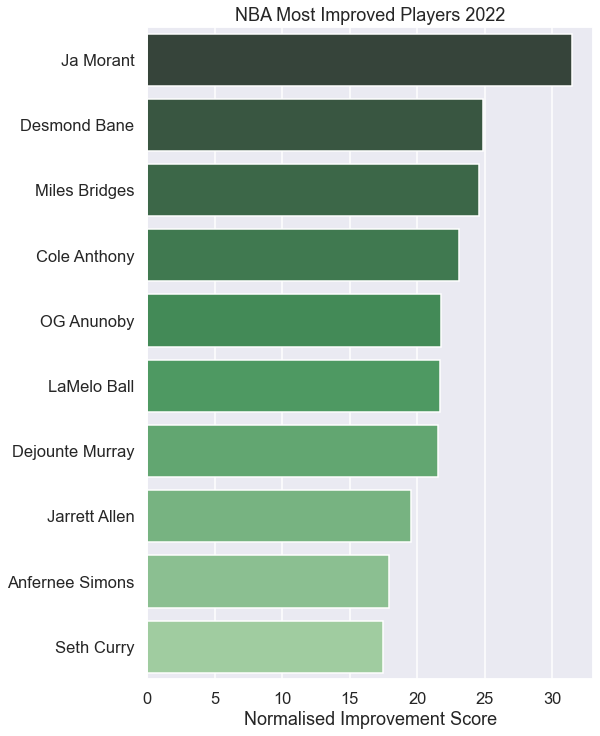

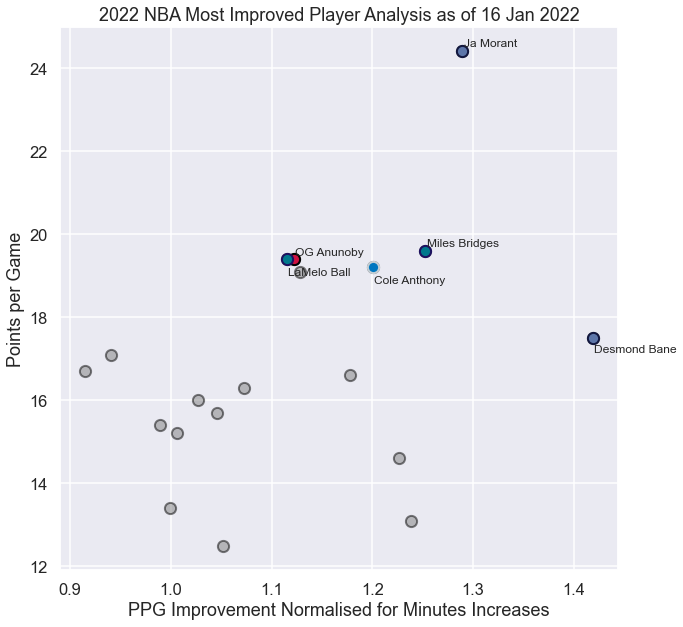

In [23]:
df = year_dataframes[2022]

#Only look at players with a PPG Improvement Ratio of at least 1.2
df = df[df['PPG_Ratio'] >= 1.2].reset_index(drop=True)

#Filtering out players mentioned
players_to_remove = ['DeMar DeRozan', 'Tyler Herro', 
                     'Ricky Rubio', 'Kevin Love', 'Reggie Jackson', 'Spencer Dinwiddie', 'Marcus Morris']

df = df[~df['Player'].isin(players_to_remove)].reset_index(drop=True)

score = df[['Player','Normalised_Improvement_Score']].sort_values(by='Normalised_Improvement_Score',
                                                                  ascending=False).reset_index(drop=True).head(10)
#Plot 1
plt.figure(figsize=(8,12))

sns.set_context('talk')

pal = sns.color_palette("Greens_d", len(score))
rank = score['Normalised_Improvement_Score'].argsort()

sns.barplot(y='Player',x='Normalised_Improvement_Score',data=score,palette=np.array(pal[::1])[rank])

plt.title('NBA Most Improved Players 2022')

plt.xlabel('Normalised Improvement Score')

plt.ylabel("")

#Plot 2
plt.figure(figsize=(10,10))

#Plot the data
sns.scatterplot(x='Norm_PPG_Ratio',y='PPG',data=df,s=125,color='grey',edgecolor='black',linewidth=2,alpha=0.5)

#Take the top three favourites from the betting market and note them on the plot
players_of_note = list(df.sort_values(by='Normalised_Improvement_Score',ascending=False)['Player'][:6])

for i,player in enumerate(players_of_note):
    
    player_index = df[df['Player']==player].index
    player_data = df[df['Player']==player]
    
    team = player_data['Team'].item()
    colour1 = team_colours[team]['primary']
    colour2 = team_colours[team]['secondary']
    
    #Plot the player in a different colour
    sns.scatterplot(x='Norm_PPG_Ratio',y='PPG',data=player_data,s=125,
                    color=colour1,edgecolor=colour2,linewidth=2)
    
    #Label the player on the plot
    if i % 2 == 0:
        x = 0.005
    else:
        x = -0.02
    plt.text(np.array(df.iloc[player_index]['Norm_PPG_Ratio'])[0]*(1+0.001),
             np.array(df.iloc[player_index]['PPG'])[0]*(1+x),
             np.array(df.iloc[player_index]['Player'])[0],
            fontdict={'size':12})

#Label the graph
plt.xlabel('PPG Improvement Normalised for Minutes Increases')
plt.ylabel('Points per Game')
today = date.today().strftime('%d %b %Y')
plt.title(str(2022) + ' NBA Most Improved Player Analysis as of ' + today)
plt.tight_layout

#Save a copy of todays standings to compare over time
if date.today().weekday() in [0,4]:
    plt.savefig('MIP Analysis ' + today, bbox_inches='tight')